In [ ]:
import re
import pandas as pd
import numpy as np
from typing import List, Dict
!pip install flashtext vaderSentiment
from flashtext import KeywordProcessor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
from datetime import timedelta, datetime
import joblib
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import os
import statsmodels.api as sm
import itertools
from collections import defaultdict
import random






[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Load company data and news
company_data = pd.read_csv("company_data_rework.csv")
#company data is created via a query from yahoo finance to reflect information such as mangement team, industry etc. the name recognition pipeline is made to be scalable to more advanced llm based methods to cover wider macro schocks.


news_benzinga = pd.read_csv("path")



In [4]:
common_suffixes = ["inc", "inc.", "corp", "corp.", "ltd", "ltd.", "plc", "co", "co.", "s.a.", "s.p.a.", "ag"]

def clean_company_name(name: str) -> str:
    """Removes common suffixes from company names."""
    name = re.sub(r'[^a-zA-Z0-9 ]', '', name)  # Remove punctuation
    for suffix in common_suffixes:
        name = re.sub(rf'\b{suffix}\b', '', name, flags=re.IGNORECASE).strip()
    return name



In [5]:

# Build company lookup dictionary
company_data["clean_name"] = company_data["Name"].apply(clean_company_name)
company_lookup = dict(zip(company_data["Ticker"], company_data["clean_name"]))

In [6]:
# Build FlashText KeywordProcessor
keyword_processor = KeywordProcessor()
for ticker, name in company_lookup.items():
    keyword_processor.add_keyword(name, ticker)
    keyword_processor.add_keyword(ticker, ticker)

def find_mentioned_companies(title: str):
    if pd.isna(title):
        return "N/A"
    matches = list(set(keyword_processor.extract_keywords(title.lower())))
    return matches if matches else "N/A"

In [7]:
# Apply company lookup to news headlines
news_benzinga["mentioned_companies"] = news_benzinga["headline"].apply(find_mentioned_companies)

news_benzinga = news_benzinga[news_benzinga["mentioned_companies"].notna()]

news_benzinga["mentioned_companies"] = news_benzinga["mentioned_companies"].apply(lambda x: [] if x == "N/A" else x)

news_benzinga = news_benzinga[news_benzinga["mentioned_companies"].apply(lambda x: len(x) > 0)]

In [8]:
# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

def extract_company_sentiment(title: str, mentioned_companies: List[str]):
    """
    Computes sentiment scores for each company mentioned in a headline.
    Instead of using the full title's sentiment, we focus on the words around each company.
    """
    company_sentiments = []
    
    for company in mentioned_companies:
        # Create a regex pattern to find the company in the text
        pattern = rf'\b{re.escape(company)}\b'
        match = re.search(pattern, title, re.IGNORECASE)

        if match:
            # Extract words near the company mention
            start, end = match.start(), match.end()
            context_window = 20
            context = title[max(0, start - context_window): min(len(title), end + context_window)]

            # Compute sentiment score on the extracted context
            sentiment = analyzer.polarity_scores(context)
            company_sentiments.append(sentiment["pos"] - sentiment["neg"])
        else:
            # If company isn't directly found (rare case), use full title sentiment
            sentiment = analyzer.polarity_scores(title)
            company_sentiments.append(sentiment["pos"] - sentiment["neg"])
    
    return company_sentiments

# Apply the improved function to compute sentiment scores per company
news_benzinga["sentiment_scores"] = news_benzinga.apply(
    lambda row: extract_company_sentiment(row["headline"], row["mentioned_companies"]), axis=1
)

news_benzinga["date_processed"] = pd.to_datetime(news_benzinga["date"], utc=True, errors='coerce').dt.date

In [9]:
# Aggregate into nested dictionary: date -> {ticker -> list of scores}
def build_daily_score_dict(df: pd.DataFrame) -> Dict[str, Dict[str, List[float]]]:
    daily_scores = {}
    for _, row in df.iterrows():
        date = str(row["date_processed"])
        tickers = row["mentioned_companies"]
        scores = row["sentiment_scores"]

        if date not in daily_scores:
            daily_scores[date] = {}

        for ticker, score in zip(tickers, scores):
            if ticker not in daily_scores[date]:
                daily_scores[date][ticker] = []
            daily_scores[date][ticker].append(score)

    return daily_scores

# Aggregate into nested dictionary: ticker -> {date -> list of scores}
def build_ticker_score_dict(df: pd.DataFrame) -> Dict[str, Dict[str, List[float]]]:
    ticker_scores = {}
    for _, row in df.iterrows():
        date = str(row["date_processed"])
        tickers = row["mentioned_companies"]
        scores = row["sentiment_scores"]

        for ticker, score in zip(tickers, scores):
            if ticker not in ticker_scores:
                ticker_scores[ticker] = {}
            if date not in ticker_scores[ticker]:
                ticker_scores[ticker][date] = []
            ticker_scores[ticker][date].append(score)

    return ticker_scores


In [10]:
# Create the nested sentiment dictionaries
sentiment_by_date = build_daily_score_dict(news_benzinga)
sentiment_by_ticker = build_ticker_score_dict(news_benzinga)

# Display a sample entry from each
print("Sample date-level entry:", list(sentiment_by_date.items())[0])
print("Sample ticker-level entry:", list(sentiment_by_ticker.items())[0])

# Display results
news_benzinga.head()

#pd.DataFrame.from_dict(sentiment_by_date, orient="index").to_csv("sentiment_by_date.csv")

Sample date-level entry: ('2020-03-20', {'C': [-0.13, -0.143, 0.0, -0.13, -0.143, -0.13, 0.0, -0.13, -0.143, -0.13, -0.143, -0.143, -0.13, -0.143, 0.072, -0.143, 0.015, -0.143, -0.12, 0.297], 'AAPL': [0.0], 'ACN': [-0.143, -0.143, -0.308], 'MS': [-0.308, -0.12, -0.286, -0.13], 'AMAT': [-0.134, 0.161, 0.0], 'AMD': [0.0, 0.161, 0.0], 'FAST': [0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268], 'EL': [0.0], 'CME': [0.0], 'CMI': [0.072], 'COP': [-0.143], 'K': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'NDAQ': [0.0, 0.0, 0.0], 'DLTR': [-0.217], 'DRI': [-0.111, 0.03699999999999999, -0.13, 0.04400000000000001, -0.12, -0.12, -0.308], 'ENPH': [0.231], 'EOG': [-0.176], 'EPAM': [-0.176, 0.0], 'KEY': [0.066], 'NFLX': [-0.12000000000000002, 0.18599999999999997, 0.068, -0.12000000000000002], 'FMC': [-0.444], 'FTNT': [-0.12], 'GILD': [-0.294], 'UPS': [-0.216], 'UBER': [0.0, 0.0], 'MET': [-0.176], 'MU': [-0.134], 'PANW': [-0.103], 'PEP': [0.08, 0.13, 0.0], 'PRU': [-0.111], 'COST': [0.0

,Unnamed: 0,headline,url,publisher,date,stock,mentioned_companies,sentiment_scores,date_processed
37,37,Citigroup Maintains Neutral on Agilent Technol...,https://www.benzinga.com/news/20/03/15615851/c...,Vick Meyer,2020-03-20 00:00:00,A,[C],[-0.13],2020-03-20
68,68,Citigroup Initiates Coverage On Agilent Techno...,https://www.benzinga.com/news/20/01/15082753/c...,Benzinga_Newsdesk,2020-01-07 00:00:00,A,[C],[0.0],2020-01-07
97,97,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-02 00:00:00,A,[ADP],[-0.293],2019-10-02
98,98,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/09/14...,Benzinga Newsdesk,2019-09-05 00:00:00,A,[C],[0.0],2019-09-05
113,113,Agilent Announces Settlement of Key Intellectu...,https://www.benzinga.com/news/19/08/14177141/a...,Charles Gross,2019-08-01 00:00:00,A,[KEY],[0.398],2019-08-01


In [11]:
def get_news_based_date_ranges(df: pd.DataFrame) -> Dict[str, List[str]]:
    ranges = {}
    for ticker, group in df.explode("mentioned_companies").groupby("mentioned_companies"):
        dates = pd.to_datetime(group["date_processed"], errors='coerce').dropna()
        if not dates.empty:
            start = (dates.min() - timedelta(days=2)).strftime("%Y-%m-%d")
            end = (dates.max() + timedelta(days=2)).strftime("%Y-%m-%d")
            ranges[ticker] = [start, end]
    return ranges

def collect_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    try:
        return yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval='1d',
    group_by='ticker',
    auto_adjust=True,
    multi_level_index=False  
)
    except:
        return pd.DataFrame()

In [12]:
# Build smart date ranges for each mentioned stock
target_date_ranges = get_news_based_date_ranges(news_benzinga)

# Collect stock price data
stock_price_data = {
    ticker: collect_stock_data(ticker, date_range[0], date_range[1])
    for ticker, date_range in target_date_ranges.items()}


joblib.dump(stock_price_data, "exptest2_27_04_stock_price_data.pkl")
joblib.dump(sentiment_by_ticker, "exptest2_27_04_sentiment_by_ticker.pkl")
joblib.dump(sentiment_by_date, "exptest2_27_04_sentiment_by_date.pkl")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABBV']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABNB']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACN']: YFRateLimitError('Too Many Requests. Rate limite

['exptest2_27_04_sentiment_by_date.pkl']

In [21]:
stock_price_data = joblib.load("exptest2_27_04_stock_price_data.pkl")
sentiment_by_ticker = joblib.load("exptest2_27_04_sentiment_by_ticker.pkl")
sentiment_by_date = joblib.load("exptest2_27_04_sentiment_by_date.pkl")
stock_price_data['AAPL']
testdf = sentiment_by_ticker['AAPL']
testvec = testdf["2011-02-22"]


In [22]:
def process_sentiment_and_returns(sentiment_dict, returns_dict, lag_days=0):
    results = {}

    for ticker in sentiment_dict.keys():
        # Check if both sentiment and returns are available
        if ticker not in returns_dict:
            print(f"Ticker {ticker} missing from returns_dict. Skipping.")
            continue
        
        # Process sentiment
        sent_raw = sentiment_dict[ticker]
        
        if len(sent_raw) == 0:
            print(f"Sentiment data empty for {ticker}. Skipping.")
            continue

        # Convert sentiment dict to DataFrame
        try:
            sent_df = pd.DataFrame({
                pd.to_datetime(date): np.mean(scores) if len(scores) > 0 else np.nan
                for date, scores in sent_raw.items()
            }, index=[0]).T
            sent_df.columns = ['avg_sentiment']
            sent_df = sent_df.dropna()
        except Exception as e:
            print(f"Error processing sentiment for {ticker}: {e}")
            continue

        # Process returns
        ret_df = returns_dict[ticker].copy()
        if ret_df.empty:
            print(f"Returns data empty for {ticker}. Skipping.")
            continue
        
        # Compute daily returns
        ret_df['Return'] = ret_df['Close'].pct_change()
        ret_df = ret_df.dropna()

        # Merge sentiment and returns
        merged = pd.merge(
            ret_df[['Return']],
            sent_df,
            left_index=True,
            right_index=True,
            how='inner'
        )

        if merged.empty:
            print(f"No overlapping dates for {ticker} after merge. Skipping.")
            continue

        # Apply lag if needed
        if lag_days > 0:
            merged['avg_sentiment'] = merged['avg_sentiment'].shift(lag_days)
            merged = merged.dropna()

        if merged.empty:
            print(f"No data left after applying lag for {ticker}. Skipping.")
            continue

        # Regress Return ~ avg_sentiment
        X = merged[['avg_sentiment']].values
        y = merged['Return'].values

        model = LinearRegression()
        model.fit(X, y)

        # Store result
        results[ticker] = {
            'coef': model.coef_[0],
            'intercept': model.intercept_,
            'r2': model.score(X, y),
            'n_obs': len(y)
        }

    return pd.DataFrame(results).T


In [23]:
test_results_0lag = process_sentiment_and_returns(sentiment_by_ticker, stock_price_data, lag_days=0)

/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Returns data empty for CEG. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Returns data empty for ABNB. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Returns data empty for CARR. Skipping.
Returns data empty for SOLV. Skipping.
Ticker IQV missing from returns_dict. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266:

In [24]:
test_results_1lag = process_sentiment_and_returns(sentiment_by_ticker, stock_price_data, lag_days=1)

No data left after applying lag for NWSA. Skipping.
Returns data empty for CEG. Skipping.
No data left after applying lag for LW. Skipping.
Returns data empty for ABNB. Skipping.
No data left after applying lag for FOXA. Skipping.
No data left after applying lag for CTVA. Skipping.
Returns data empty for CARR. Skipping.
No data left after applying lag for FTV. Skipping.
Returns data empty for SOLV. Skipping.
No data left after applying lag for LHX. Skipping.
No data left after applying lag for TFC. Skipping.
No data left after applying lag for VTRS. Skipping.
No data left after applying lag for BKNG. Skipping.
Ticker IQV missing from returns_dict. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [25]:
test_results_2lag = process_sentiment_and_returns(sentiment_by_ticker, stock_price_data, lag_days=2)

No data left after applying lag for NWSA. Skipping.
Returns data empty for CEG. Skipping.
No data left after applying lag for LW. Skipping.
Returns data empty for ABNB. Skipping.
No data left after applying lag for FOXA. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


No data left after applying lag for CTVA. Skipping.
Returns data empty for CARR. Skipping.
No data left after applying lag for ATO. Skipping.
No data left after applying lag for FTV. Skipping.
Returns data empty for SOLV. Skipping.
No data left after applying lag for KHC. Skipping.
No data left after applying lag for LHX. Skipping.
No data left after applying lag for TFC. Skipping.
No data left after applying lag for VTRS. Skipping.
No data left after applying lag for BKNG. Skipping.
Ticker IQV missing from returns_dict. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [26]:
test_results_1wklag = process_sentiment_and_returns(sentiment_by_ticker, stock_price_data, lag_days=7)

No data left after applying lag for NWSA. Skipping.
No data left after applying lag for FRT. Skipping.
Returns data empty for CEG. Skipping.
No data left after applying lag for ZBH. Skipping.
No data left after applying lag for HUBB. Skipping.
No data left after applying lag for JKHY. Skipping.
No data left after applying lag for LW. Skipping.
No data left after applying lag for SNA. Skipping.
Returns data empty for ABNB. Skipping.
No data left after applying lag for LKQ. Skipping.
No data left after applying lag for FOXA. Skipping.
No data left after applying lag for OTIS. Skipping.
No data left after applying lag for PYPL. Skipping.
No data left after applying lag for STE. Skipping.


/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


No data left after applying lag for TDG. Skipping.
No data left after applying lag for CTVA. Skipping.
No data left after applying lag for WST. Skipping.
No data left after applying lag for BKR. Skipping.
No data left after applying lag for VICI. Skipping.
No data left after applying lag for APTV. Skipping.
No data left after applying lag for ODFL. Skipping.
No data left after applying lag for INVH. Skipping.
Returns data empty for CARR. Skipping.
No data left after applying lag for TPL. Skipping.
No data left after applying lag for ATO. Skipping.
No data left after applying lag for FTV. Skipping.
No data left after applying lag for TDY. Skipping.
Returns data empty for SOLV. Skipping.
No data left after applying lag for PARA. Skipping.
No data left after applying lag for KHC. Skipping.
No data left after applying lag for LHX. Skipping.
No data left after applying lag for TFC. Skipping.
No data left after applying lag for VTRS. Skipping.
No data left after applying lag for BKNG. Skippi

/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/matteici/Documents/GitHub/Financial-Article-Scrapper/google_factiva_test/test_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [27]:
def run_regressions(sentiment, returns_dict, lag_days=0, extreme_percent=None, min_obs=30):
    results = {}

    for ticker in returns_dict.keys():
        if ticker not in sentiment:
            print(f"Sentiment data missing for {ticker}. Skipping.")
            continue

        stock_returns = returns_dict[ticker]
        ticker_sentiment = sentiment[ticker]

        if not ticker_sentiment or stock_returns.empty:
            print(f"Empty data for {ticker}. Skipping.")
            continue

        # Step 1: Build sentiment dataframe
        sentiment_df = pd.DataFrame.from_dict(ticker_sentiment, orient='index')
        sentiment_df.index = pd.to_datetime(sentiment_df.index)
        sentiment_df.sort_index(inplace=True)

        # Step 2: Average sentiment per day
        sentiment_df['average_sentiment'] = sentiment_df.apply(lambda row: np.mean(row.dropna().tolist()) if not row.isnull().all() else np.nan, axis=1)
        sentiment_series = sentiment_df['average_sentiment'].dropna()

        # Step 3: Filter stocks with too few observations
        if len(sentiment_series) < min_obs:
            print(f"Not enough sentiment observations for {ticker}. Skipping.")
            continue

        # Step 4: Prepare returns
        stock_returns = stock_returns.copy()
        stock_returns['Return'] = stock_returns['Close'].pct_change()
        stock_returns = stock_returns.dropna()

        # Step 5: Align data
        aligned = pd.DataFrame({
            'Return': stock_returns['Return'],
            'Sentiment': sentiment_series
        }).dropna()

        # Step 6: Apply lagging if needed
        if lag_days > 0:
            aligned['Sentiment'] = aligned['Sentiment'].shift(lag_days)
            aligned = aligned.dropna()

        # Step 7: Select extreme sentiment days
        if extreme_percent is not None:
            lower_thresh = aligned['Sentiment'].quantile(extreme_percent)
            upper_thresh = aligned['Sentiment'].quantile(1 - extreme_percent)
            aligned = aligned[(aligned['Sentiment'] <= lower_thresh) | (aligned['Sentiment'] >= upper_thresh)]

        if len(aligned) < 10:  # Still need enough data
            print(f"Not enough data after extreme filtering for {ticker}. Skipping.")
            continue

        # Step 8: Run regression
        X = sm.add_constant(aligned['Sentiment'])
        y = aligned['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model

    return results

In [28]:

test_new_file = run_regressions(sentiment=sentiment_by_ticker, returns_dict=stock_price_data, lag_days=0, extreme_percent=0.1, min_obs=30)
print(test_new_file['AAPL'].summary())
test_new_file_1dlag = run_regressions(sentiment=sentiment_by_ticker, returns_dict=stock_price_data, lag_days=1, extreme_percent=0.1, min_obs=30)
print(test_new_file_1dlag['AAPL'].summary())
test_new_file_1dlag0_2 = run_regressions(sentiment=sentiment_by_ticker, returns_dict=stock_price_data, lag_days=1, extreme_percent=0.2, min_obs=30)
print(test_new_file_1dlag0_2['AAPL'].summary())
test_new_file_0lag0_0_5 = run_regressions(sentiment=sentiment_by_ticker, returns_dict=stock_price_data, lag_days=0, extreme_percent=0.05, min_obs=30)
print(test_new_file_0lag0_0_5['AAPL'].summary())
test_new_file_1lag0_0_5 = run_regressions(sentiment=sentiment_by_ticker, returns_dict=stock_price_data, lag_days=1, extreme_percent=0.05, min_obs=30)
print(test_new_file_1lag0_0_5['AAPL'].summary())

Empty data for ABNB. Skipping.
Not enough sentiment observations for AMCR. Skipping.
Not enough sentiment observations for ANSS. Skipping.
Not enough sentiment observations for AOS. Skipping.
Not enough sentiment observations for APD. Skipping.
Not enough sentiment observations for APTV. Skipping.
Not enough sentiment observations for ATO. Skipping.
Not enough sentiment observations for AWK. Skipping.
Not enough sentiment observations for BKNG. Skipping.
Not enough sentiment observations for BKR. Skipping.
Not enough sentiment observations for BRO. Skipping.
Empty data for CARR. Skipping.
Empty data for CEG. Skipping.
Not enough sentiment observations for CHRW. Skipping.
Not enough sentiment observations for CINF. Skipping.
Not enough sentiment observations for CNP. Skipping.
Not enough sentiment observations for COR. Skipping.
Not enough sentiment observations for CTVA. Skipping.
Not enough data after extreme filtering for CZR. Skipping.
Not enough sentiment observations for EG. Skipp

In [29]:

def run_regression_with_compounded_sentiment(sentiment_dict, returns_dict, 
                                              lag_days=0, 
                                              extreme_percentile=0.1, 
                                              min_obs=30, 
                                              compounding_days=3):
    """
    Run OLS regression of stock returns on sentiment with lagging, extreme filtering, 
    and compounded sentiment over past few days.

    Parameters:
    - sentiment_dict: dict of dicts, each ticker's date -> list of sentiment values
    - returns_dict: dict of DataFrames, each ticker's price data
    - lag_days: int, how many days to lag the sentiment
    - extreme_percentile: float between 0 and 0.5, fraction for extreme sentiment filtering
    - min_obs: minimum number of observations to run regression
    - compounding_days: int, how many past days to average sentiment over
    """
    
    results = {}

    for ticker in sentiment_dict:
        if ticker not in returns_dict:
            print(f"Missing returns for {ticker}, skipping...")
            continue

        # Build sentiment dataframe
        sent_df = pd.DataFrame([
            (pd.to_datetime(date), sum(vals)/len(vals) if len(vals) > 0 else None)
            for date, vals in sentiment_dict[ticker].items()
        ], columns=["Date", "Sentiment"]).dropna()

        if sent_df.empty or returns_dict[ticker].empty:
            print(f"Empty data for {ticker}, skipping...")
            continue

        sent_df = sent_df.set_index("Date").sort_index()

        # Smooth sentiment: compound sentiment over past n days
        sent_df['Compounded_Sentiment'] = sent_df['Sentiment'].rolling(window=compounding_days, min_periods=1).mean()

        # Merge with returns
        price_df = returns_dict[ticker].copy()
        price_df['Return'] = price_df['Close'].pct_change()
        
        merged = pd.merge(price_df[['Return']], sent_df[['Compounded_Sentiment']], 
                          left_index=True, right_index=True, how='inner')

        # Apply lag
        if lag_days > 0:
            merged['Compounded_Sentiment'] = merged['Compounded_Sentiment'].shift(lag_days)
            merged = merged.dropna()

        if len(merged) < min_obs:
            print(f"Not enough data for {ticker}, skipping...")
            continue

        # Select extreme values
        lower_thresh = merged['Compounded_Sentiment'].quantile(extreme_percentile)
        upper_thresh = merged['Compounded_Sentiment'].quantile(1 - extreme_percentile)
        extreme_merged = merged[
            (merged['Compounded_Sentiment'] <= lower_thresh) | 
            (merged['Compounded_Sentiment'] >= upper_thresh)
        ]

        if len(extreme_merged) < min_obs:
            print(f"Not enough extreme observations for {ticker}, skipping...")
            continue

        # Regression
        X = sm.add_constant(extreme_merged['Compounded_Sentiment'])
        y = extreme_merged['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model
    
    return results

In [30]:
test_comp_sent = run_regression_with_compounded_sentiment(sentiment_dict = sentiment_by_ticker, returns_dict = stock_price_data, 
                                              lag_days=0, 
                                              extreme_percentile=0.1, 
                                              min_obs=30, 
                                              compounding_days=3)
print(test_comp_sent['AAPL'].summary())

Not enough extreme observations for PSX, skipping...
Not enough extreme observations for KEYS, skipping...
Not enough extreme observations for PH, skipping...
Not enough extreme observations for SLB, skipping...
Not enough extreme observations for WAT, skipping...
Not enough extreme observations for DELL, skipping...
Not enough extreme observations for MAS, skipping...
Not enough extreme observations for ACGL, skipping...
Not enough extreme observations for DIS, skipping...
Not enough extreme observations for URI, skipping...
Not enough extreme observations for SYY, skipping...
Not enough extreme observations for TER, skipping...
Not enough extreme observations for IR, skipping...
Not enough extreme observations for KR, skipping...
Not enough extreme observations for MRNA, skipping...
Not enough data for SMCI, skipping...
Not enough extreme observations for ISRG, skipping...
Not enough extreme observations for STX, skipping...
Not enough extreme observations for CAG, skipping...
Not en

In [31]:
def run_regression_on_sentiments(sentiment_dict, returns_dict, 
                                 lag_days=0, 
                                 extreme_percentile=0.1, 
                                 min_obs=30, 
                                 compounding_days=3):
    """
    Run OLS regression of stock returns on both today's sentiment and compounded past sentiment.

    Parameters:
    - sentiment_dict: dict of dicts, each ticker's date -> list of sentiment values
    - returns_dict: dict of DataFrames, each ticker's price data
    - lag_days: int, how many days to lag the sentiment
    - extreme_percentile: float between 0 and 0.5, fraction for extreme sentiment filtering
    - min_obs: minimum number of observations to run regression
    - compounding_days: int, how many past days to average sentiment over
    """
    
    results = {}

    for ticker in sentiment_dict:
        if ticker not in returns_dict:
            print(f"Missing returns for {ticker}, skipping...")
            continue

        # Build sentiment dataframe
        sent_df = pd.DataFrame([
            (pd.to_datetime(date), sum(vals)/len(vals) if len(vals) > 0 else None)
            for date, vals in sentiment_dict[ticker].items()
        ], columns=["Date", "Sentiment"]).dropna()

        if sent_df.empty or returns_dict[ticker].empty:
            print(f"Empty data for {ticker}, skipping...")
            continue

        sent_df = sent_df.set_index("Date").sort_index()

        # Smooth sentiment: compound sentiment over past n days
        sent_df['Compounded_Sentiment'] = sent_df['Sentiment'].rolling(window=compounding_days, min_periods=1).mean()

        # Merge with returns
        price_df = returns_dict[ticker].copy()
        price_df['Return'] = price_df['Close'].pct_change()
        
        merged = pd.merge(price_df[['Return']], sent_df[['Sentiment', 'Compounded_Sentiment']], 
                          left_index=True, right_index=True, how='inner')

        # Apply lag
        if lag_days > 0:
            merged['Sentiment'] = merged['Sentiment'].shift(lag_days)
            merged['Compounded_Sentiment'] = merged['Compounded_Sentiment'].shift(lag_days)
            merged = merged.dropna()

        if len(merged) < min_obs:
            print(f"Not enough data for {ticker}, skipping...")
            continue

        # Select extreme values
        lower_thresh_sent = merged['Sentiment'].quantile(extreme_percentile)
        upper_thresh_sent = merged['Sentiment'].quantile(1 - extreme_percentile)
        lower_thresh_comp = merged['Compounded_Sentiment'].quantile(extreme_percentile)
        upper_thresh_comp = merged['Compounded_Sentiment'].quantile(1 - extreme_percentile)

        extreme_merged = merged[
            ((merged['Sentiment'] <= lower_thresh_sent) | (merged['Sentiment'] >= upper_thresh_sent)) |
            ((merged['Compounded_Sentiment'] <= lower_thresh_comp) | (merged['Compounded_Sentiment'] >= upper_thresh_comp))
        ]

        if len(extreme_merged) < min_obs:
            print(f"Not enough extreme observations for {ticker}, skipping...")
            continue

        # Regression on both variables
        X = extreme_merged[['Sentiment', 'Compounded_Sentiment']]
        X = sm.add_constant(X)
        y = extreme_merged['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model
    
    return results

In [32]:
test_mult_regr_comp = run_regression_on_sentiments(sentiment_dict = sentiment_by_ticker, returns_dict = stock_price_data, 
                                 lag_days=0, 
                                 extreme_percentile=0.05, 
                                 min_obs=30, 
                                 compounding_days=5)

print(test_mult_regr_comp['AAPL'].summary())

Not enough extreme observations for PSX, skipping...
Not enough extreme observations for KEYS, skipping...
Not enough extreme observations for PH, skipping...
Not enough extreme observations for SLB, skipping...
Not enough extreme observations for WAT, skipping...
Not enough extreme observations for DELL, skipping...
Not enough extreme observations for MAS, skipping...
Not enough extreme observations for ACGL, skipping...
Not enough extreme observations for AME, skipping...
Not enough extreme observations for URI, skipping...
Not enough extreme observations for SYY, skipping...
Not enough extreme observations for TER, skipping...
Not enough extreme observations for IR, skipping...
Not enough extreme observations for KR, skipping...
Not enough extreme observations for MRNA, skipping...
Not enough data for SMCI, skipping...
Not enough extreme observations for ISRG, skipping...
Not enough extreme observations for WFC, skipping...
Not enough extreme observations for STX, skipping...
Not en

In [33]:
def run_regression_on_sentiments(sentiment_dict, returns_dict, 
                                 lag_days=0, 
                                 extreme_percentile=0.1, 
                                 min_obs=30, 
                                 compounding_days=3,
                                 abs_sentiment_threshold=0.0):
    """
    Run OLS regression of stock returns on both today's sentiment and compounded past sentiment.

    Filters:
    - Only keeps sentiment observations where |sentiment| > abs_sentiment_threshold
    - Then, keeps top and bottom extreme_percentile of sentiments
    """

    results = {}

    for ticker in sentiment_dict:
        if ticker not in returns_dict:
            print(f"Missing returns for {ticker}, skipping...")
            continue

        # Build sentiment dataframe
        sent_df = pd.DataFrame([
            (pd.to_datetime(date), sum(vals)/len(vals) if len(vals) > 0 else None)
            for date, vals in sentiment_dict[ticker].items()
        ], columns=["Date", "Sentiment"]).dropna()

        if sent_df.empty or returns_dict[ticker].empty:
            print(f"Empty data for {ticker}, skipping...")
            continue

        sent_df = sent_df.set_index("Date").sort_index()

        # Filter by absolute sentiment strength
        sent_df = sent_df[sent_df['Sentiment'].abs() > abs_sentiment_threshold]

        if sent_df.empty:
            print(f"No strong sentiment data for {ticker} after abs filtering, skipping...")
            continue

        # Smooth sentiment: compound over past n days
        sent_df['Compounded_Sentiment'] = sent_df['Sentiment'].rolling(window=compounding_days, min_periods=1).mean()

        # Merge with returns
        price_df = returns_dict[ticker].copy()
        price_df['Return'] = price_df['Close'].pct_change()
        
        merged = pd.merge(price_df[['Return']], sent_df[['Sentiment', 'Compounded_Sentiment']], 
                          left_index=True, right_index=True, how='inner')

        # Apply lag
        if lag_days > 0:
            merged['Sentiment'] = merged['Sentiment'].shift(lag_days)
            merged['Compounded_Sentiment'] = merged['Compounded_Sentiment'].shift(lag_days)
            merged = merged.dropna()

        if len(merged) < min_obs:
            print(f"Not enough data for {ticker} after lagging, skipping...")
            continue

        # Now take only extreme values
        lower_thresh_sent = merged['Sentiment'].quantile(extreme_percentile)
        upper_thresh_sent = merged['Sentiment'].quantile(1 - extreme_percentile)
        lower_thresh_comp = merged['Compounded_Sentiment'].quantile(extreme_percentile)
        upper_thresh_comp = merged['Compounded_Sentiment'].quantile(1 - extreme_percentile)

        extreme_merged = merged[
            ((merged['Sentiment'] <= lower_thresh_sent) | (merged['Sentiment'] >= upper_thresh_sent)) |
            ((merged['Compounded_Sentiment'] <= lower_thresh_comp) | (merged['Compounded_Sentiment'] >= upper_thresh_comp))
        ]

        if len(extreme_merged) < min_obs:
            print(f"Not enough extreme observations for {ticker}, skipping...")
            continue

        # Regression on both variables
        X = extreme_merged[['Sentiment', 'Compounded_Sentiment']]
        X = sm.add_constant(X)
        y = extreme_merged['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model
    
    return results

test_compund_extreme_extreme = run_regression_on_sentiments(sentiment_dict = sentiment_by_ticker, returns_dict = stock_price_data, 
                                 lag_days=0, 
                                 extreme_percentile=0.1, 
                                 min_obs=30, 
                                 compounding_days=3,
                                 abs_sentiment_threshold=0.15)

print(test_compund_extreme_extreme['AAPL'].summary())

Not enough extreme observations for ADP, skipping...
Not enough extreme observations for DLTR, skipping...
Not enough data for PSX after lagging, skipping...
Not enough extreme observations for DXCM, skipping...
Not enough extreme observations for GEN, skipping...
Not enough extreme observations for NTAP, skipping...
Not enough extreme observations for AMP, skipping...
Not enough extreme observations for TMO, skipping...
Not enough extreme observations for AMGN, skipping...
Not enough extreme observations for PSA, skipping...
Not enough data for BXP after lagging, skipping...
Not enough extreme observations for TJX, skipping...
Not enough data for KEYS after lagging, skipping...
Not enough data for PH after lagging, skipping...
Not enough extreme observations for ED, skipping...
Not enough extreme observations for DFS, skipping...
Not enough data for SBUX after lagging, skipping...
Not enough data for AON after lagging, skipping...
Not enough extreme observations for NVDA, skipping...


In [34]:
def run_regression_on_sentiments(sentiment_dict, returns_dict, 
                                 lag_days=0, 
                                 extreme_percentile=0.1, 
                                 min_obs=30, 
                                 compounding_days=3,
                                 abs_sentiment_threshold=0.0,
                                 use_log_returns=False):
    """
    Run OLS regression of stock returns (regular or log) on both today's sentiment and compounded past sentiment.

    Parameters:
        - sentiment_dict: dict of {ticker: {date: [sentiments]}}
        - returns_dict: dict of {ticker: DataFrame with OHLCV}
        - lag_days: int, how many days to lag sentiment
        - extreme_percentile: float (0 to 0.5), percent of extremes to keep
        - min_obs: int, minimum data points needed to run regression
        - compounding_days: int, window size for sentiment compounding
        - abs_sentiment_threshold: float, minimum absolute sentiment to keep
        - use_log_returns: bool, use log returns instead of simple returns

    Returns:
        - dict of {ticker: OLS regression results}
    """
    
    results = {}

    for ticker in sentiment_dict:
        if ticker not in returns_dict:
            print(f"Missing returns for {ticker}, skipping...")
            continue

        # Build sentiment dataframe
        sent_df = pd.DataFrame([
            (pd.to_datetime(date), sum(vals)/len(vals) if len(vals) > 0 else None)
            for date, vals in sentiment_dict[ticker].items()
        ], columns=["Date", "Sentiment"]).dropna()

        if sent_df.empty or returns_dict[ticker].empty:
            print(f"Empty data for {ticker}, skipping...")
            continue

        sent_df = sent_df.set_index("Date").sort_index()

        # Filter by absolute sentiment strength
        sent_df = sent_df[sent_df['Sentiment'].abs() > abs_sentiment_threshold]

        if sent_df.empty:
            print(f"No strong sentiment data for {ticker} after abs filtering, skipping...")
            continue

        # Compounded sentiment
        sent_df['Compounded_Sentiment'] = sent_df['Sentiment'].rolling(window=compounding_days, min_periods=1).mean()

        # Merge with returns
        price_df = returns_dict[ticker].copy()
        price_df = price_df.sort_index()

        # Create return variable
        if use_log_returns:
            price_df['Return'] = np.log(price_df['Close']) - np.log(price_df['Close'].shift(1))
        else:
            price_df['Return'] = price_df['Close'].pct_change()

        merged = pd.merge(price_df[['Return']], sent_df[['Sentiment', 'Compounded_Sentiment']], 
                          left_index=True, right_index=True, how='inner')

        # Apply lag
        if lag_days > 0:
            merged['Sentiment'] = merged['Sentiment'].shift(lag_days)
            merged['Compounded_Sentiment'] = merged['Compounded_Sentiment'].shift(lag_days)
            merged = merged.dropna()

        if len(merged) < min_obs:
            print(f"Not enough data for {ticker} after lagging, skipping...")
            continue

        # Filter extreme values
        lower_thresh_sent = merged['Sentiment'].quantile(extreme_percentile)
        upper_thresh_sent = merged['Sentiment'].quantile(1 - extreme_percentile)
        lower_thresh_comp = merged['Compounded_Sentiment'].quantile(extreme_percentile)
        upper_thresh_comp = merged['Compounded_Sentiment'].quantile(1 - extreme_percentile)

        extreme_merged = merged[
            ((merged['Sentiment'] <= lower_thresh_sent) | (merged['Sentiment'] >= upper_thresh_sent)) |
            ((merged['Compounded_Sentiment'] <= lower_thresh_comp) | (merged['Compounded_Sentiment'] >= upper_thresh_comp))
        ]

        if len(extreme_merged) < min_obs:
            print(f"Not enough extreme observations for {ticker}, skipping...")
            continue

        # Regression
        X = extreme_merged[['Sentiment', 'Compounded_Sentiment']]
        X = sm.add_constant(X)
        y = extreme_merged['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model

    return results
new_test = run_regression_on_sentiments(sentiment_dict = sentiment_by_ticker, returns_dict = stock_price_data, 
                                 lag_days=1, 
                                 extreme_percentile=0.2, 
                                 min_obs=30, 
                                 compounding_days=5,
                                 abs_sentiment_threshold=0.1,
                                 use_log_returns=True)

print(new_test['AAPL'].summary())

Not enough extreme observations for PSX, skipping...
Not enough data for BXP after lagging, skipping...
Not enough extreme observations for KEYS, skipping...
Not enough data for PH after lagging, skipping...
Not enough data for SBUX after lagging, skipping...
Not enough extreme observations for AON, skipping...
Not enough data for SLB after lagging, skipping...
Not enough data for WAT after lagging, skipping...
Not enough data for DELL after lagging, skipping...
Not enough data for OMC after lagging, skipping...
Not enough data for MAS after lagging, skipping...
Not enough extreme observations for MGM, skipping...
Not enough extreme observations for ACGL, skipping...
Not enough extreme observations for AME, skipping...
Not enough data for DIS after lagging, skipping...
Not enough data for SYY after lagging, skipping...
Not enough data for TER after lagging, skipping...
Not enough extreme observations for GS, skipping...
Not enough data for IR after lagging, skipping...
Not enough data 

In [35]:
def run_regression_on_sentiments(
    sentiment_dict, returns_dict, 
    lag_days=0, 
    extreme_percentile=0.1, 
    min_obs=30, 
    compounding_days=3,
    abs_sentiment_threshold=0.0,
    use_log_returns=False,
    compounding_returns_days=None  # NEW ARGUMENT
):
    """
    Run OLS regression of (log) returns on today's sentiment and compounded sentiment.

    If use_log_returns is True and compounding_returns_days is set,
    the dependent variable will be compounded log returns.
    """

    results = {}

    for ticker in sentiment_dict:
        if ticker not in returns_dict:
            print(f"Missing returns for {ticker}, skipping...")
            continue

        # Build sentiment dataframe
        sent_df = pd.DataFrame([
            (pd.to_datetime(date), sum(vals)/len(vals) if len(vals) > 0 else None)
            for date, vals in sentiment_dict[ticker].items()
        ], columns=["Date", "Sentiment"]).dropna()

        if sent_df.empty or returns_dict[ticker].empty:
            print(f"Empty data for {ticker}, skipping...")
            continue

        sent_df = sent_df.set_index("Date").sort_index()
        sent_df = sent_df[sent_df['Sentiment'].abs() > abs_sentiment_threshold]

        if sent_df.empty:
            print(f"No strong sentiment data for {ticker}, skipping...")
            continue

        # Compounded sentiment
        sent_df['Compounded_Sentiment'] = sent_df['Sentiment'].rolling(window=compounding_days, min_periods=1).mean()

        price_df = returns_dict[ticker].copy().sort_index()

        # Create returns
        if use_log_returns:
            price_df['Return'] = np.log(price_df['Close']) - np.log(price_df['Close'].shift(1))

            # Optional compounding of log returns
            if compounding_returns_days is not None and compounding_returns_days > 1:
                price_df['Return'] = price_df['Return'].rolling(window=compounding_returns_days).sum()
        else:
            price_df['Return'] = price_df['Close'].pct_change()

        merged = pd.merge(price_df[['Return']], sent_df[['Sentiment', 'Compounded_Sentiment']],
                          left_index=True, right_index=True, how='inner')

        # Apply lag
        if lag_days > 0:
            merged['Sentiment'] = merged['Sentiment'].shift(lag_days)
            merged['Compounded_Sentiment'] = merged['Compounded_Sentiment'].shift(lag_days)
            merged = merged.dropna()

        if len(merged) < min_obs:
            print(f"Not enough data for {ticker}, skipping...")
            continue

        # Extreme filtering
        lower_s, upper_s = merged['Sentiment'].quantile(extreme_percentile), merged['Sentiment'].quantile(1 - extreme_percentile)
        lower_c, upper_c = merged['Compounded_Sentiment'].quantile(extreme_percentile), merged['Compounded_Sentiment'].quantile(1 - extreme_percentile)

        merged = merged[
            (merged['Sentiment'] <= lower_s) | (merged['Sentiment'] >= upper_s) |
            (merged['Compounded_Sentiment'] <= lower_c) | (merged['Compounded_Sentiment'] >= upper_c)
        ]

        if len(merged) < min_obs:
            print(f"Not enough extreme obs for {ticker}, skipping...")
            continue

        # Regression
        X = sm.add_constant(merged[['Sentiment', 'Compounded_Sentiment']])
        y = merged['Return']
        model = sm.OLS(y, X).fit()

        results[ticker] = model

    return results

newnew_test = run_regression_on_sentiments(
    sentiment_dict = sentiment_by_ticker, returns_dict = stock_price_data, 
    lag_days=0, 
    extreme_percentile=0.1, 
    min_obs=30, 
    compounding_days=3,
    abs_sentiment_threshold=0.15,
    use_log_returns=True,
    compounding_returns_days=2  # NEW ARGUMENT
)

print(newnew_test['AAPL'].summary())

Not enough extreme obs for ADP, skipping...
Not enough extreme obs for DLTR, skipping...
Not enough data for PSX, skipping...
Not enough extreme obs for DXCM, skipping...
Not enough extreme obs for GEN, skipping...
Not enough extreme obs for NTAP, skipping...
Not enough extreme obs for AMP, skipping...
Not enough extreme obs for TMO, skipping...
Not enough extreme obs for AMGN, skipping...
Not enough extreme obs for PSA, skipping...
Not enough data for BXP, skipping...
Not enough extreme obs for TJX, skipping...
Not enough data for KEYS, skipping...
Not enough data for PH, skipping...
Not enough extreme obs for ED, skipping...
Not enough extreme obs for DFS, skipping...
Not enough data for SBUX, skipping...
Not enough data for AON, skipping...
Not enough extreme obs for NVDA, skipping...
Not enough data for SLB, skipping...
Not enough data for WAT, skipping...
Not enough extreme obs for DVA, skipping...
Not enough data for DELL, skipping...
Not enough data for OMC, skipping...
Not enou

In [36]:

newnewnew_test = results = run_regression_on_sentiments(
    sentiment_dict = sentiment_by_ticker,
    returns_dict = stock_price_data,
    lag_days=2,
    extreme_percentile=0.05,
    min_obs=30,
    compounding_days=7,
    abs_sentiment_threshold=0.15,
    use_log_returns=True,
    compounding_returns_days=5
)


print(newnewnew_test['AAPL'].summary())

Not enough extreme obs for ADP, skipping...
Not enough extreme obs for DLTR, skipping...
Not enough extreme obs for EA, skipping...
Not enough extreme obs for WMT, skipping...
Not enough data for PSX, skipping...
Not enough extreme obs for DXCM, skipping...
Not enough extreme obs for GEN, skipping...
Not enough extreme obs for IP, skipping...
Not enough extreme obs for NTAP, skipping...
Not enough extreme obs for AMP, skipping...
Not enough extreme obs for TMO, skipping...
Not enough extreme obs for AMGN, skipping...
Not enough extreme obs for PSA, skipping...
Not enough extreme obs for GRMN, skipping...
Not enough data for BXP, skipping...
Not enough extreme obs for TJX, skipping...
Not enough data for KEYS, skipping...
Not enough extreme obs for IBM, skipping...
Not enough data for PH, skipping...
Not enough extreme obs for ED, skipping...
Not enough extreme obs for DFS, skipping...
Not enough data for SBUX, skipping...
Not enough extreme obs for UPS, skipping...
Not enough data for 

In [37]:
#IGNORE
'''

def grid_search_loosened(sentiment, returns_dict, lags=[0], 
                         min_obs_list=[10, 30], 
                         percentile_list=[0.05, 0.10], 
                         abs_threshold_list=[0.0, 0.1],
                         comp_days_list=[0, 3],
                         use_log_returns=True):
    
    results = []

    for lag in lags:
        for min_obs in min_obs_list:
            for percentile in percentile_list:
                for abs_thresh in abs_threshold_list:
                    for comp_days in comp_days_list:

                        for ticker in sentiment:
                            if ticker not in returns_dict:
                                continue

                            df_sent_raw = sentiment[ticker]
                            if not isinstance(df_sent_raw, pd.DataFrame):
                                continue

                            df_ret = returns_dict[ticker]
                            if df_ret.empty:
                                continue

                            # Flatten list of sentiment values into average
                            df_sent = df_sent_raw.copy()
                            df_sent["Sentiment"] = df_sent["Sentiment"].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
                            df_sent.dropna(subset=["Sentiment"], inplace=True)

                            # Add compounding sentiment
                            if comp_days > 0:
                                df_sent["Sentiment_Comp"] = df_sent["Sentiment"].rolling(window=comp_days).mean()
                            else:
                                df_sent["Sentiment_Comp"] = df_sent["Sentiment"]

                            df_sent = df_sent.dropna()

                            if len(df_sent) < min_obs:
                                continue

                            # Apply absolute sentiment threshold
                            df_sent = df_sent[df_sent["Sentiment"].abs() >= abs_thresh]
                            if len(df_sent) < min_obs:
                                continue

                            # Apply top/bottom x% filter
                            cutoff = df_sent["Sentiment"].quantile([percentile, 1 - percentile])
                            lower, upper = cutoff.iloc[0], cutoff.iloc[1]
                            df_sent = df_sent[(df_sent["Sentiment"] <= lower) | (df_sent["Sentiment"] >= upper)]
                            if len(df_sent) < min_obs:
                                continue

                            df_ret = df_ret.copy()
                            if use_log_returns:
                                df_ret["Return"] = np.log(df_ret["Close"]).diff()
                            else:
                                df_ret["Return"] = df_ret["Close"].pct_change()

                            # Lagging
                            if lag > 0:
                                df_sent_lagged = df_sent.shift(lag)
                                df_sent_lagged.columns = [col + f"_lag{lag}" for col in df_sent.columns]
                                combined = pd.concat([df_ret, df_sent_lagged], axis=1)
                                combined.dropna(subset=[f"Sentiment_lag{lag}", f"Sentiment_Comp_lag{lag}", "Return"], inplace=True)
                                X = combined[[f"Sentiment_lag{lag}", f"Sentiment_Comp_lag{lag}"]]
                            else:
                                combined = pd.concat([df_ret, df_sent], axis=1)
                                combined.dropna(subset=["Sentiment", "Sentiment_Comp", "Return"], inplace=True)
                                X = combined[["Sentiment", "Sentiment_Comp"]]

                            y = combined["Return"]
                            if len(X) < min_obs:
                                continue

                            X = sm.add_constant(X)
                            model = sm.OLS(y, X).fit()

                            results.append({
                                "Ticker": ticker,
                                "Lag": lag,
                                "Min Obs": min_obs,
                                "Percentile": percentile,
                                "Abs Threshold": abs_thresh,
                                "Comp Days": comp_days,
                                "R2": model.rsquared,
                                "P-Value Sent": model.pvalues.get("Sentiment" if lag == 0 else f"Sentiment_lag{lag}", np.nan),
                                "P-Value Comp": model.pvalues.get("Sentiment_Comp" if lag == 0 else f"Sentiment_Comp_lag{lag}", np.nan),
                                "N Obs": len(X)
                            })

    return pd.DataFrame(results)

df_results = grid_search_loosened(sentiment = sentiment_by_ticker, returns_dict=stock_price_data)

'''

'\n\ndef grid_search_loosened(sentiment, returns_dict, lags=[0], \n                         min_obs_list=[10, 30], \n                         percentile_list=[0.05, 0.10], \n                         abs_threshold_list=[0.0, 0.1],\n                         comp_days_list=[0, 3],\n                         use_log_returns=True):\n    \n    results = []\n\n    for lag in lags:\n        for min_obs in min_obs_list:\n            for percentile in percentile_list:\n                for abs_thresh in abs_threshold_list:\n                    for comp_days in comp_days_list:\n\n                        for ticker in sentiment:\n                            if ticker not in returns_dict:\n                                continue\n\n                            df_sent_raw = sentiment[ticker]\n                            if not isinstance(df_sent_raw, pd.DataFrame):\n                                continue\n\n                            df_ret = returns_dict[ticker]\n                            if df

In [ ]:
# Define grid of parameters to search over
param_grid = {
    'abs_sentiment_threshold': [0.0, 0.1, 0.2],
    'extreme_percentile': [0.1, 0.2],
    'min_obs': [30, 50],
    'compounding_days': [3],
    'lag_days': [0, 1],
    'use_log_returns': [True, False],
    'compounding_returns_days': [None, 3]
}

'''
Try expanding to:

Lag: {1, 2, 3, 4, 5}

Compounding: {1, 3, 5, 7}
'''


# Create all combinations of parameters
param_names = list(param_grid.keys())
param_combinations = list(itertools.product(*param_grid.values()))

# Store grid search results
grid_results = []

for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    
    try:
        models = run_regression_on_sentiments(
            sentiment_dict=sentiment_by_ticker,
            returns_dict=stock_price_data,
            **params
        )
        
        # Extract R² values from the returned models
        r_squareds = [model.rsquared for model in models.values() if model is not None]
        
        if r_squareds:
            mean_r2 = np.mean(r_squareds)
            result_entry = {**params, 'mean_r_squared': mean_r2, 'n_models': len(r_squareds)}
            grid_results.append(result_entry)
    
    except Exception as e:
        print(f"Error with params {params}: {e}")

# Convert results to DataFrame
grid_search_df = pd.DataFrame(grid_results)
grid_search_df = grid_search_df.sort_values(by='mean_r_squared', ascending=False).reset_index(drop=True)

Not enough extreme obs for PSX, skipping...
Not enough extreme obs for GEN, skipping...
Not enough extreme obs for TMO, skipping...
Not enough data for BXP, skipping...
Not enough extreme obs for KEYS, skipping...
Not enough data for PH, skipping...
Not enough extreme obs for DFS, skipping...
Not enough data for SBUX, skipping...
Not enough extreme obs for AON, skipping...
Not enough data for SLB, skipping...
Not enough data for WAT, skipping...
Not enough data for DELL, skipping...
Not enough extreme obs for OMC, skipping...
Not enough extreme obs for MAS, skipping...
Not enough extreme obs for MGM, skipping...
Not enough extreme obs for ACGL, skipping...
Not enough extreme obs for AME, skipping...
Not enough extreme obs for DHI, skipping...
Not enough data for DIS, skipping...
Not enough data for SYY, skipping...
Not enough extreme obs for JPM, skipping...
Not enough extreme obs for CSCO, skipping...
Not enough data for TER, skipping...
Not enough extreme obs for MA, skipping...
Not 

In [39]:
joblib.dump(grid_search_df, "exptest2_27_04_grid_search_df.pkl")

#grid_search_df = joblib.load("exptest2_27_04_grid_search_df.pkl")



['exptest2_27_04_grid_search_df.pkl']

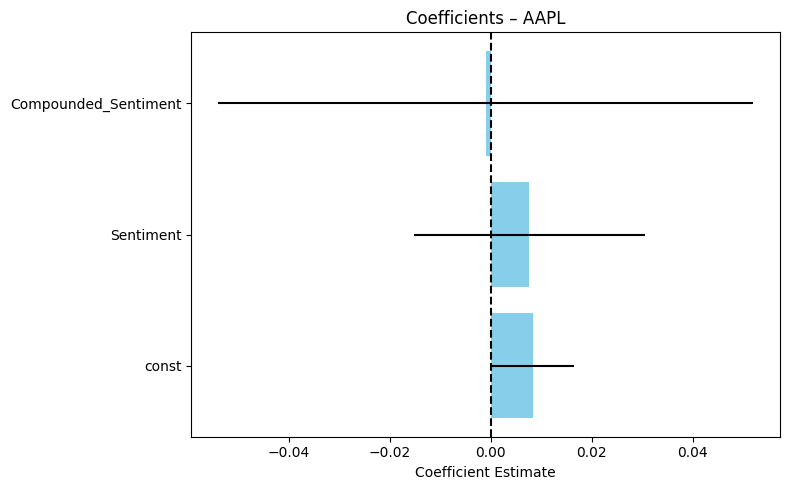

/var/folders/gm/kf61wf7d0rngwszt66rdf98r0000gn/T/ipykernel_58583/2615247665.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_models, y="label", x="mean_r_squared", palette="Blues_d")


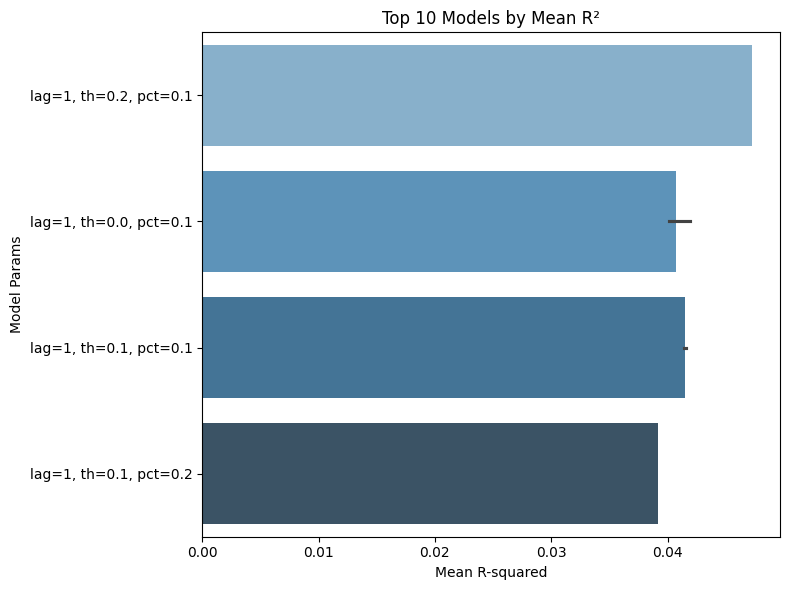

In [40]:
# Coefficient Plot 
def plot_coefficients(result, title="Regression Coefficients", filename="regression_coefficients.png"):
    coef_df = pd.DataFrame({
        "Variable": result.params.index,
        "Estimate": result.params.values,
        "StdErr": result.bse.values
    })
    fig, ax = plt.subplots(figsize=(8, 5))
    y_pos = np.arange(len(coef_df))
    ax.barh(y=y_pos, width=coef_df["Estimate"], xerr=1.96 * coef_df["StdErr"], color="skyblue")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(coef_df["Variable"])
    ax.axvline(0, color="black", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Coefficient Estimate")
    plt.tight_layout()
    plt.savefig("regression_coefficients.png")
    plt.show()

# Use any regression model from your experiments here
plot_coefficients(newnewnew_test["AAPL"], title="Coefficients – AAPL")

# === 2. R² Comparison Plot from grid_search_df ===
top_models = grid_search_df.copy().sort_values("mean_r_squared", ascending=False).head(10)
top_models["label"] = top_models.apply(
    lambda row: f"lag={row['lag_days']}, th={row['abs_sentiment_threshold']}, pct={row['extreme_percentile']}",
    axis=1
)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_models, y="label", x="mean_r_squared", palette="Blues_d")
plt.title("Top 10 Models by Mean R²")
plt.xlabel("Mean R-squared")
plt.ylabel("Model Params")
plt.tight_layout()
plt.savefig("r2_comparison.png")
plt.show()


In [41]:


'''
# Load saved data
sentiment_by_ticker = joblib.load("exptest2_27_04_sentiment_by_ticker.pkl")
stock_price_data = joblib.load("exptest2_27_04_stock_price_data.pkl")
grid_search_df = joblib.load("exptest2_27_04_grid_search_df.pkl")
'''

# Parameters
TICKERS_TO_ANALYZE = ['AAPL', 'TSLA', 'ACN']
EXTREME_PERCENTILE = 0.1
LAG_DAYS = 1
COMPOUND_DAYS = 5
ABS_THRESHOLD = 0.15
MIN_OBS = 30


In [42]:

# Run Regressions for Selected Tickers 
regression_summaries = {}

for ticker in TICKERS_TO_ANALYZE:
    if ticker not in sentiment_by_ticker or ticker not in stock_price_data:
        continue
    
    sent_dict = sentiment_by_ticker[ticker]
    prices = stock_price_data[ticker].copy()
    
    # Build sentiment DataFrame
    sent_df = pd.DataFrame([
        (pd.to_datetime(date), np.mean(vals) if vals else None)
        for date, vals in sent_dict.items()
    ], columns=["Date", "Sentiment"]).dropna()
    sent_df = sent_df.set_index("Date").sort_index()
    sent_df = sent_df[sent_df["Sentiment"].abs() > ABS_THRESHOLD]
    sent_df["Compounded_Sentiment"] = sent_df["Sentiment"].rolling(COMPOUND_DAYS, min_periods=1).mean()

    # Build return DataFrame
    prices = prices.sort_index()
    prices["Return"] = np.log(prices["Close"]) - np.log(prices["Close"].shift(1))
    prices = prices[["Return"]].dropna()

    df = pd.merge(prices, sent_df, left_index=True, right_index=True, how="inner")
    if LAG_DAYS > 0:
        df["Sentiment"] = df["Sentiment"].shift(LAG_DAYS)
        df["Compounded_Sentiment"] = df["Compounded_Sentiment"].shift(LAG_DAYS)
        df = df.dropna()

    if len(df) < MIN_OBS:
        continue

    # Filter extremes
    lower_s, upper_s = df["Sentiment"].quantile(EXTREME_PERCENTILE), df["Sentiment"].quantile(1 - EXTREME_PERCENTILE)
    lower_c, upper_c = df["Compounded_Sentiment"].quantile(EXTREME_PERCENTILE), df["Compounded_Sentiment"].quantile(1 - EXTREME_PERCENTILE)
    df = df[(df["Sentiment"] <= lower_s) | (df["Sentiment"] >= upper_s) |
            (df["Compounded_Sentiment"] <= lower_c) | (df["Compounded_Sentiment"] >= upper_c)]

    if len(df) < MIN_OBS:
        continue

    X = sm.add_constant(df[["Sentiment", "Compounded_Sentiment"]])
    y = df["Return"]
    model = sm.OLS(y, X).fit()
    regression_summaries[ticker] = model


In [43]:

# Print Summaries 
for ticker, model in regression_summaries.items():
    print(f"\n========== {ticker} ==========")
    print(model.summary())



========== AAPL ==========
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.1932
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.825
Time:                        17:53:17   Log-Likelihood:                 361.37
No. Observations:                 141   AIC:                            -716.7
Df Residuals:                     138   BIC:                            -707.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
cons

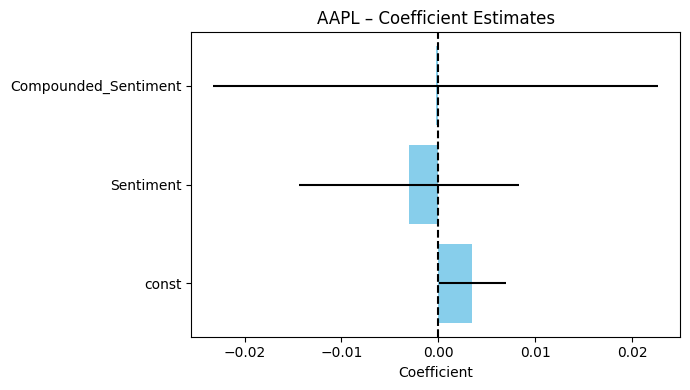

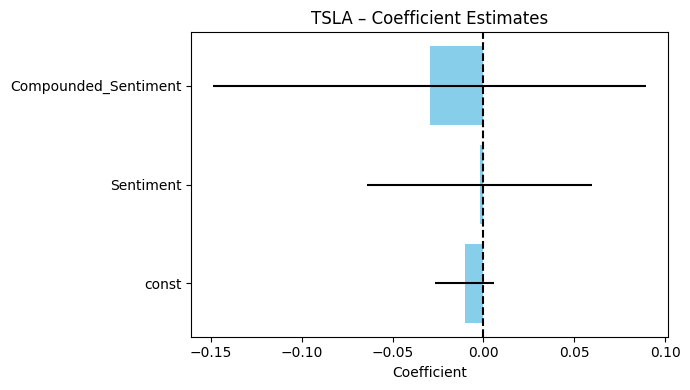

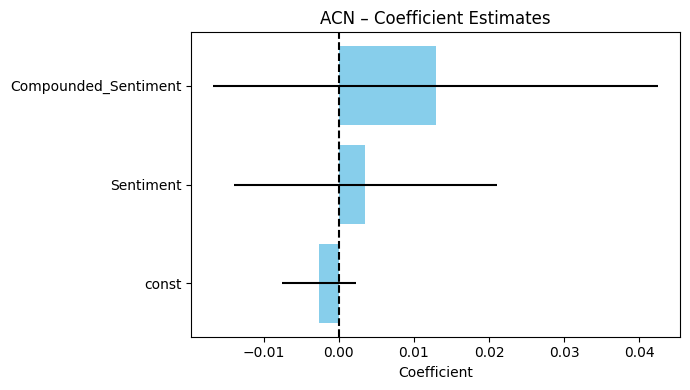

In [44]:

# Coefficient Plots
for ticker, model in regression_summaries.items():
    coefs = model.params
    stderr = model.bse
    fig, ax = plt.subplots(figsize=(7, 4))
    y_pos = np.arange(len(coefs))
    ax.barh(y_pos, coefs.values, xerr=1.96 * stderr.values, color="skyblue")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(coefs.index)
    ax.axvline(0, color="black", linestyle="--")
    ax.set_title(f"{ticker} – Coefficient Estimates")
    ax.set_xlabel("Coefficient")
    plt.tight_layout()
    plt.savefig(f"{ticker}_coef_plot.png")
    plt.show()

# Histogram of R² Values for All Tickers
all_r2 = []
for ticker in sentiment_by_ticker:
    if ticker not in stock_price_data:
        continue

    sent_dict = sentiment_by_ticker[ticker]
    prices = stock_price_data[ticker].copy()

    sent_df = pd.DataFrame([
        (pd.to_datetime(date), np.mean(vals) if vals else None)
        for date, vals in sent_dict.items()
    ], columns=["Date", "Sentiment"]).dropna().set_index("Date").sort_index()

    sent_df["Compounded_Sentiment"] = sent_df["Sentiment"].rolling(COMPOUND_DAYS, min_periods=1).mean()
    sent_df = sent_df[sent_df["Sentiment"].abs() > ABS_THRESHOLD]
    prices["Return"] = np.log(prices["Close"]) - np.log(prices["Close"].shift(1))

    df = pd.merge(prices[["Return"]], sent_df[["Sentiment", "Compounded_Sentiment"]], 
                  left_index=True, right_index=True, how="inner").dropna()

    if len(df) < MIN_OBS:
        continue

    X = sm.add_constant(df[["Sentiment", "Compounded_Sentiment"]])
    y = df["Return"]
    try:
        r2 = sm.OLS(y, X).fit().rsquared
        all_r2.append(r2)
    except:
        continue


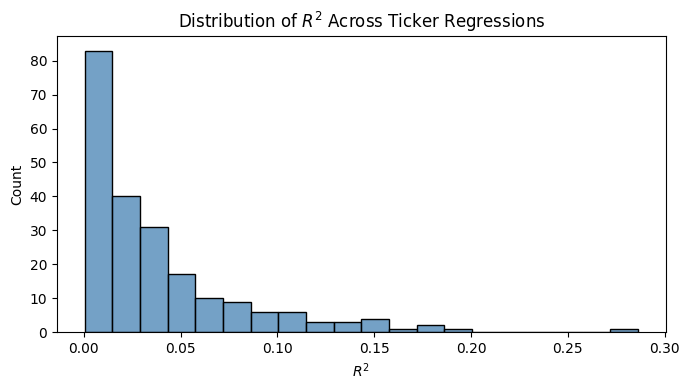

In [45]:
plt.figure(figsize=(7, 4))
sns.histplot(all_r2, bins=20, kde=False, color="steelblue")
plt.xlabel("$R^2$")
plt.title("Distribution of $R^2$ Across Ticker Regressions")
plt.tight_layout()
plt.savefig("r2_distribution.png")
plt.show()

In [46]:
top_grid = grid_search_df.sort_values("mean_r_squared", ascending=False).head(10)
print("\nTop 10 Grid Search Models by Mean R²:")
print(top_grid[["lag_days", "abs_sentiment_threshold", "extreme_percentile", "compounding_days", "mean_r_squared"]])


Top 10 Grid Search Models by Mean R²:
   lag_days  abs_sentiment_threshold  extreme_percentile  compounding_days  \
0         1                      0.2                 0.1                 3   
1         1                      0.0                 0.1                 3   
2         1                      0.1                 0.1                 3   
3         1                      0.1                 0.1                 3   
4         1                      0.1                 0.1                 3   
5         1                      0.1                 0.1                 3   
6         1                      0.0                 0.1                 3   
7         1                      0.0                 0.1                 3   
8         1                      0.0                 0.1                 3   
9         1                      0.1                 0.2                 3   

   mean_r_squared  
0        0.047284  
1        0.042503  
2        0.041547  
3        0.041547  
4 

In [47]:
'''
common_suffixes = ["inc", "inc.", "corp", "corp.", "ltd", "ltd.", "plc", "co", "co.", "s.a.", "s.p.a.", "ag"]
def clean_company_name(name: str) -> str:
    name = re.sub(r'[^a-zA-Z0-9 ]', '', name)
    for suffix in common_suffixes:
        name = re.sub(rf'\b{suffix}\b', '', name, flags=re.IGNORECASE).strip()
    return name

company_data["clean_name"] = company_data["Name"].apply(clean_company_name)
company_lookup = dict(zip(company_data["Ticker"], company_data["clean_name"]))

# FlashText for matching
keyword_processor = KeywordProcessor()
for ticker, name in company_lookup.items():
    keyword_processor.add_keyword(name, ticker)
    keyword_processor.add_keyword(ticker, ticker)

def find_mentioned_companies(title):
    if pd.isna(title):
        return []
    return list(set(keyword_processor.extract_keywords(title.lower())))

news_benzinga["mentioned_companies"] = news_benzinga["headline"].apply(find_mentioned_companies)
news_benzinga = news_benzinga[news_benzinga["mentioned_companies"].apply(lambda x: len(x) > 0)]
news_benzinga["date_processed"] = pd.to_datetime(news_benzinga["date"], utc=True, errors='coerce').dt.date
'''

'\ncommon_suffixes = ["inc", "inc.", "corp", "corp.", "ltd", "ltd.", "plc", "co", "co.", "s.a.", "s.p.a.", "ag"]\ndef clean_company_name(name: str) -> str:\n    name = re.sub(r\'[^a-zA-Z0-9 ]\', \'\', name)\n    for suffix in common_suffixes:\n        name = re.sub(rf\'\x08{suffix}\x08\', \'\', name, flags=re.IGNORECASE).strip()\n    return name\n\ncompany_data["clean_name"] = company_data["Name"].apply(clean_company_name)\ncompany_lookup = dict(zip(company_data["Ticker"], company_data["clean_name"]))\n\n# FlashText for matching\nkeyword_processor = KeywordProcessor()\nfor ticker, name in company_lookup.items():\n    keyword_processor.add_keyword(name, ticker)\n    keyword_processor.add_keyword(ticker, ticker)\n\ndef find_mentioned_companies(title):\n    if pd.isna(title):\n        return []\n    return list(set(keyword_processor.extract_keywords(title.lower())))\n\nnews_benzinga["mentioned_companies"] = news_benzinga["headline"].apply(find_mentioned_companies)\nnews_benzinga = news_be

In [48]:
'''
# Sentiment scoring
analyzer = SentimentIntensityAnalyzer()
def extract_company_sentiment(title, mentioned_companies):
    results = []
    for company in mentioned_companies:
        if pd.isna(title):
            results.append(0)
            continue
        pattern = rf'\b{re.escape(company)}\b'
        match = re.search(pattern, title, re.IGNORECASE)
        if match:
            context = title[max(0, match.start() - 20): match.end() + 20]
        else:
            context = title
        sentiment = analyzer.polarity_scores(context)
        results.append(sentiment["pos"] - sentiment["neg"])
    return results

news_benzinga["sentiment_scores"] = news_benzinga.apply(
    lambda row: extract_company_sentiment(row["headline"], row["mentioned_companies"]), axis=1
)
'''

'\n# Sentiment scoring\nanalyzer = SentimentIntensityAnalyzer()\ndef extract_company_sentiment(title, mentioned_companies):\n    results = []\n    for company in mentioned_companies:\n        if pd.isna(title):\n            results.append(0)\n            continue\n        pattern = rf\'\x08{re.escape(company)}\x08\'\n        match = re.search(pattern, title, re.IGNORECASE)\n        if match:\n            context = title[max(0, match.start() - 20): match.end() + 20]\n        else:\n            context = title\n        sentiment = analyzer.polarity_scores(context)\n        results.append(sentiment["pos"] - sentiment["neg"])\n    return results\n\nnews_benzinga["sentiment_scores"] = news_benzinga.apply(\n    lambda row: extract_company_sentiment(row["headline"], row["mentioned_companies"]), axis=1\n)\n'

In [49]:

# Build ticker -> date -> sentiment dictionary
def build_ticker_score_dict(df):
    ticker_scores = {}
    for _, row in df.iterrows():
        date = str(row["date_processed"])
        tickers = row["mentioned_companies"]
        scores = row["sentiment_scores"]
        for ticker, score in zip(tickers, scores):
            if ticker not in ticker_scores:
                ticker_scores[ticker] = {}
            if date not in ticker_scores[ticker]:
                ticker_scores[ticker][date] = []
            ticker_scores[ticker][date].append(score)
    return ticker_scores

sentiment_by_ticker = build_ticker_score_dict(news_benzinga)



# Example: Ticker list from sentiment data
tickers = list(sentiment_by_ticker.keys())

# Define date range based on your sentiment data
all_sentiment_dates = []
for ticker_data in sentiment_by_ticker.values():
    all_sentiment_dates.extend(pd.to_datetime(list(ticker_data.keys()), errors='coerce'))

start_date = str(min(all_sentiment_dates).date())
end_date = str(max(all_sentiment_dates).date())


In [50]:

# Download function
def download_price_and_volatility(ticker_list, start_date, end_date, volatility_window=5):
    price_data = {}
    for ticker in ticker_list:
        try:
            df = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                interval='1d',
                group_by='ticker',
                auto_adjust=True,
                multi_level_index=False
            )
            if not df.empty:
                df['Return'] = np.log(df['Close']).diff()
                df['Volatility'] = df['Return'].rolling(window=volatility_window).std()
                price_data[ticker] = df
        except Exception as e:
            print(f"Failed for {ticker}: {e}")
    return price_data
'''
# Run the download
stock_price_data = download_price_and_volatility(
    ticker_list=tickers,
    start_date=start_date,
    end_date=end_date,
    volatility_window=5
)
'''

# Load the price data
#stock_price_data = joblib.load("exptest2_27_04_stock_price_data.pkl")

'\n# Run the download\nstock_price_data = download_price_and_volatility(\n    ticker_list=tickers,\n    start_date=start_date,\n    end_date=end_date,\n    volatility_window=5\n)\n'

In [51]:

# Load the price data
#stock_price_data = joblib.load("exptest2_27_04_stock_price_data.pkl")

# Process each ticker's DataFrame individually
for ticker, df in stock_price_data.items():
    if not isinstance(df, pd.DataFrame) or 'Close' not in df.columns:
        continue  # skip invalid entries

    df = df.sort_index()  # Ensure chronological order
    df['Return'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
    df['Volatility'] = df['Return'].rolling(window=20).std()

    # Save back to dict
    stock_price_data[ticker] = df

In [52]:
#Create clean long-format DataFrame from raw data
rows = []
for ticker, date_sentiments in sentiment_by_ticker.items():
    for date, sentiments in date_sentiments.items():
        if ticker in stock_price_data and date in stock_price_data[ticker].index.strftime("%Y-%m-%d"):
            try:
                dt = pd.to_datetime(date)
                daily_return = stock_price_data[ticker].loc[dt, 'Return']
                daily_vol = stock_price_data[ticker].loc[dt, 'Volatility']
                sentiment_avg = np.mean(sentiments)
                headline_count = len(sentiments)
                rows.append({
                    "Date": dt,
                    "Ticker": ticker,
                    "Sentiment": sentiment_avg,
                    "HeadlineCount": headline_count,
                    "Return": daily_return,
                    "Volatility": daily_vol
                })
            except Exception as e:
                continue

df = pd.DataFrame(rows)
df.dropna(inplace=True)


In [58]:

summary = df.groupby("Ticker")["Sentiment"].agg(["count", "mean", "std", "min", "max"])
summary.to_csv("eda_outputs/sentiment_summary.csv")


In [59]:


daily_sent = df.groupby("Date")["Sentiment"].mean().reset_index()
daily_sent.to_csv("eda_outputs/daily_sentiment.csv", index=False)


In [60]:

plt.figure(figsize=(12, 4))
sns.lineplot(data=daily_sent, x="Date", y="Sentiment")
plt.title("Average Daily Market Sentiment")
plt.tight_layout()
plt.savefig("eda_outputs/market_sentiment_timeseries.png")
plt.close()


In [61]:

# === Correlation Between Sentiment and Return ===
correlation = df[["Sentiment", "Return"]].corr().iloc[0, 1]
print(f"Correlation between sentiment and return: {correlation:.4f}")


Correlation between sentiment and return: 0.0392


In [62]:

# === Per-Ticker Insights ===
ticker_stats = df.groupby("Ticker").agg({
    "Sentiment": ["mean", "std"],
    "Return": ["mean", "std"],
    "Volatility": "mean",
    "HeadlineCount": "mean"
})
ticker_stats.columns = ["_".join(col) for col in ticker_stats.columns]
ticker_stats.to_csv("eda_outputs/ticker_stats.csv")


In [63]:
plt.figure(figsize=(6, 4))
sns.histplot(df["Sentiment"], bins=50, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.tight_layout()
plt.savefig("eda_outputs/sentiment_distribution.png")
plt.close()

def backtest_sentiment_portfolio(sentiment_dict, price_data,
                                 initial_capital=100000,
                                 sentiment_threshold=0.2,
                                 volatility_window=5):
    """
    Backtest a sentiment-based strategy with volatility-adjusted sizing.

    Parameters:
    - sentiment_dict: ticker -> date -> list of sentiment scores
    - price_data: dict of {ticker: price DataFrame with 'Return' and 'Volatility'}
    - initial_capital: float
    - sentiment_threshold: float
    - volatility_window: int (already used to compute volatility before)

    Returns:
    - DataFrame of daily returns
    - Final portfolio value
    - Sharpe ratio (annualized)
    """
    tickers = list(price_data.keys())
    
    # Extract valid start and end dates from sentiment_dict and price_data
    valid_start_dates = []
    for v in sentiment_dict.values():
        for k in v.keys():
            dt = pd.to_datetime(k, errors='coerce')
            if pd.notna(dt):
                valid_start_dates.append(dt)

    if not valid_start_dates:
        raise ValueError("No valid dates found in sentiment_dict.")

    start_date = min(valid_start_dates).date()
    end_date = max(max(df.index).date() for df in price_data.values() if not df.empty)

    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")


    portfolio_value = initial_capital
    daily_returns = []

    for current_date in all_dates:
        date_str = str(current_date.date())
        signals = {}

        for ticker in tickers:
            if ticker not in sentiment_dict or ticker not in price_data:
                continue
            if date_str in sentiment_dict[ticker]:
                avg_sent = np.mean(sentiment_dict[ticker][date_str])
                if abs(avg_sent) >= sentiment_threshold:
                    signals[ticker] = np.sign(avg_sent)

        if not signals:
            daily_returns.append(0)
            continue

        inv_vols = {}
        for ticker in signals:
            try:
                vol = price_data[ticker].loc[current_date, 'Volatility']
                if not pd.isna(vol) and vol > 0:
                    inv_vols[ticker] = 1 / vol
            except:
                continue

        if not inv_vols:
            daily_returns.append(0)
            continue

        total_inv_vol = sum(inv_vols.values())
        weights = {t: inv_vols[t] / total_inv_vol for t in inv_vols}

        portfolio_return = 0
        for ticker, direction in signals.items():
            try:
                r = price_data[ticker].loc[current_date + pd.Timedelta(days=1), 'Return']
                if not pd.isna(r):
                    portfolio_return += weights.get(ticker, 0) * direction * r
            except:
                continue

        daily_returns.append(portfolio_return)
        portfolio_value *= (1 + portfolio_return)

    daily_returns = np.array(daily_returns)
    sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252) if np.std(daily_returns) > 0 else 0
    returns_df = pd.DataFrame({'Date': all_dates, 'Daily Return': daily_returns}).set_index('Date')
    return returns_df, portfolio_value, sharpe_ratio

def run_full_backtest(sentiment_dict,
                      price_data,
                      initial_capital=100000,
                      sentiment_threshold=0.2,
                      volatility_window=5,
                      plot=True,
                      save_path="eda_outputs/backtest_performance.png"):
    """
    Wrapper for backtesting and plotting performance.
    """
    returns_df, final_val, sharpe = backtest_sentiment_portfolio(
        sentiment_dict=sentiment_dict,
        price_data=price_data,
        initial_capital=initial_capital,
        sentiment_threshold=sentiment_threshold,
        volatility_window=volatility_window
    )

    if plot:
        returns_df["Cumulative Return"] = (1 + returns_df["Daily Return"]).cumprod()
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=returns_df, x=returns_df.index, y="Cumulative Return")
        plt.title(f"Backtest Performance (Sharpe: {sharpe:.2f}, Final Value: ${final_val:,.0f})")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")

    return returns_df, final_val, sharpe


In [64]:


returns_df, final_val, sharpe = backtest_sentiment_portfolio(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    sentiment_threshold=0.2,
    volatility_window=20
)


In [65]:

returns_df, final_val, sharpe = run_full_backtest(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    sentiment_threshold=0.2,
    volatility_window=5)

print("Backtest Summary")
print(f"Final Portfolio Value: ${final_val:,.2f}")
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")

print("\nDaily Return Stats")
print(returns_df["Daily Return"].describe())

print("\nFinal Days")
print(returns_df.tail())

print("\nInitial Days")
print(returns_df.head())


Plot saved to eda_outputs/backtest_performance.png
Backtest Summary
Final Portfolio Value: $226,179.88
Annualized Sharpe Ratio: 0.50

Daily Return Stats
count    4001.000000
mean        0.000231
std         0.007331
min        -0.085415
25%        -0.000005
50%         0.000000
75%         0.000727
max         0.075389
Name: Daily Return, dtype: float64

Final Days
            Daily Return  Cumulative Return
Date                                       
2020-05-31      0.000000           2.346988
2020-06-01     -0.006048           2.332793
2020-06-02     -0.001348           2.329649
2020-06-03     -0.029125           2.261799
2020-06-04      0.000000           2.261799

Initial Days
            Daily Return  Cumulative Return
Date                                       
2009-06-22           0.0                1.0
2009-06-23           0.0                1.0
2009-06-24           0.0                1.0
2009-06-25           0.0                1.0
2009-06-26           0.0                1.0


In [66]:



def run_sentiment_extreme_backtest(
    sentiment_dict,
    price_data,
    initial_capital=100_000,
    top_n=5,
    max_hold_days=3,
    sentiment_zscore_threshold=None,
    per_ticker_stop_loss=0.05,
    max_drawdown_pct=0.2,
    volatility_window=20
):
    # Compute z-scores per ticker's sentiment
    sentiment_z = {}
    for ticker, date_dict in sentiment_dict.items():
        all_scores = []
        all_dates = []
        for date, scores in date_dict.items():
            all_scores.append(np.mean(scores))
            all_dates.append(pd.to_datetime(date))
        if len(all_scores) >= 2:
            zscores = zscore(all_scores)
            sentiment_z[ticker] = dict(zip([str(d.date()) for d in all_dates], zscores))

    tickers = list(price_data.keys())
    start_date = min(pd.to_datetime(k) for t in sentiment_dict.values() for k in t.keys())
    end_date = max(df.index.max() for df in price_data.values() if not df.empty)
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")

    portfolio_value = initial_capital
    daily_returns = []
    current_positions = {}  # ticker -> (direction, days_held, entry_price)
    peak_value = initial_capital

    for current_date in all_dates:
        date_str = str(current_date.date())

        # 1. Generate signals
        daily_signals = []
        for ticker in tickers:
            z_val = sentiment_z.get(ticker, {}).get(date_str)
            if z_val is not None:
                daily_signals.append((ticker, z_val))

        # 2. Filter signals
        if sentiment_zscore_threshold is not None:
            filtered_signals = [(t, z) for t, z in daily_signals if abs(z) >= sentiment_zscore_threshold]
        else:
            filtered_signals = sorted(daily_signals, key=lambda x: abs(x[1]), reverse=True)[:top_n]

        new_positions = {}
        for ticker, z_val in filtered_signals[:top_n]:
            direction = np.sign(z_val)
            try:
                entry_price = price_data[ticker].loc[current_date + timedelta(days=1), 'Close']
            except:
                continue
            new_positions[ticker] = (direction, 0, entry_price)  # day 0 hold starts tomorrow

        # 3. Update and carry forward positions
        updated_positions = {}
        for ticker, (direction, days_held, entry_price) in current_positions.items():
            if days_held + 1 <= max_hold_days:
                updated_positions[ticker] = (direction, days_held + 1, entry_price)

        # Overwrite with new signals
        for ticker in new_positions:
            updated_positions[ticker] = new_positions[ticker]

        # 4. Volatility-adjusted weights
        inv_vols = {}
        for ticker, (direction, _, _) in updated_positions.items():
            try:
                vol = price_data[ticker].loc[current_date, 'Volatility']
                if not pd.isna(vol) and vol > 0:
                    inv_vols[ticker] = 1 / vol
            except:
                continue

        total_inv_vol = sum(inv_vols.values())
        weights = {t: inv_vols[t] / total_inv_vol for t in inv_vols}

        # 5. Compute portfolio return
        portfolio_return = 0
        valid_tickers = list(weights.keys())
        new_positions_for_next_day = {}

        for ticker in valid_tickers:
            direction, days_held, entry_price = updated_positions[ticker]
            try:
                r = price_data[ticker].loc[current_date + timedelta(days=1), 'Return']
                price_now = price_data[ticker].loc[current_date + timedelta(days=1), 'Close']
            except:
                continue

            # Stop-loss check
            if price_now is not None and entry_price is not None:
                pnl = direction * (price_now - entry_price) / entry_price
                if pnl <= -per_ticker_stop_loss:
                    continue  # Skip position due to SL

            portfolio_return += weights.get(ticker, 0) * direction * r
            new_positions_for_next_day[ticker] = (direction, days_held, entry_price)

        current_positions = new_positions_for_next_day
        portfolio_value *= (1 + portfolio_return)
        peak_value = max(peak_value, portfolio_value)

        # Drawdown check
        drawdown = (peak_value - portfolio_value) / peak_value
        if drawdown > max_drawdown_pct:
            current_positions.clear()  # Exit to cash
            print(f"Drawdown exceeded on {current_date.date()} — exiting all positions.")

        daily_returns.append(portfolio_return)

    returns_df = pd.DataFrame({'Date': all_dates, 'Daily Return': daily_returns}).set_index('Date')
    sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252) if np.std(daily_returns) > 0 else 0

    return returns_df, portfolio_value, sharpe_ratio


In [67]:

returns_df, final_val, sharpe = run_sentiment_extreme_backtest(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    top_n=6,
    max_hold_days=3,
    sentiment_zscore_threshold=1.5,  # or None
    per_ticker_stop_loss=0.05,
    max_drawdown_pct=0.15,
    volatility_window=20
)



Drawdown exceeded on 2010-01-21 — exiting all positions.
Drawdown exceeded on 2010-01-22 — exiting all positions.
Drawdown exceeded on 2010-01-23 — exiting all positions.
Drawdown exceeded on 2010-01-24 — exiting all positions.
Drawdown exceeded on 2010-01-25 — exiting all positions.
Drawdown exceeded on 2010-01-27 — exiting all positions.
Drawdown exceeded on 2010-01-28 — exiting all positions.
Drawdown exceeded on 2010-01-29 — exiting all positions.
Drawdown exceeded on 2010-01-30 — exiting all positions.
Drawdown exceeded on 2010-01-31 — exiting all positions.
Drawdown exceeded on 2010-02-01 — exiting all positions.
Drawdown exceeded on 2010-02-02 — exiting all positions.
Drawdown exceeded on 2010-02-03 — exiting all positions.
Drawdown exceeded on 2010-02-04 — exiting all positions.
Drawdown exceeded on 2010-02-05 — exiting all positions.
Drawdown exceeded on 2010-02-06 — exiting all positions.
Drawdown exceeded on 2010-02-07 — exiting all positions.
Drawdown exceeded on 2010-02-08

In [68]:


def plot_backtest_results(returns_df, initial_capital=100_000, rolling_window=30):

    returns_df['Cumulative Return'] = (1 + returns_df['Daily Return']).cumprod()
    returns_df['Portfolio Value'] = initial_capital * returns_df['Cumulative Return']
    
    rolling_sharpe = returns_df['Daily Return'].rolling(rolling_window).apply(
        lambda x: (np.mean(x) / np.std(x)) * np.sqrt(252) if np.std(x) > 0 else 0, raw=True
    )
    
    peak = returns_df['Portfolio Value'].cummax()
    drawdown = (peak - returns_df['Portfolio Value']) / peak

    fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    
    axes[0].plot(returns_df.index, returns_df['Portfolio Value'], label='Portfolio Value', linewidth=2)
    axes[0].set_ylabel("Portfolio Value")
    axes[0].set_title("Cumulative Portfolio Value")
    axes[0].grid(True)
    
    axes[1].bar(returns_df.index, returns_df['Daily Return'], label='Daily Return', color='gray')
    axes[1].set_ylabel("Daily Return")
    axes[1].set_title("Daily Returns")
    axes[1].grid(True)
    
    axes[2].plot(returns_df.index, rolling_sharpe, label='Rolling Sharpe', color='darkgreen')
    axes[2].set_ylabel("Sharpe Ratio")
    axes[2].set_title(f"{rolling_window}-Day Rolling Sharpe Ratio")
    axes[2].grid(True)

    axes[3].fill_between(returns_df.index, drawdown, color='red', alpha=0.4, label='Drawdown')
    axes[3].set_ylabel("Drawdown")
    axes[3].set_title("Drawdown Over Time")
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()


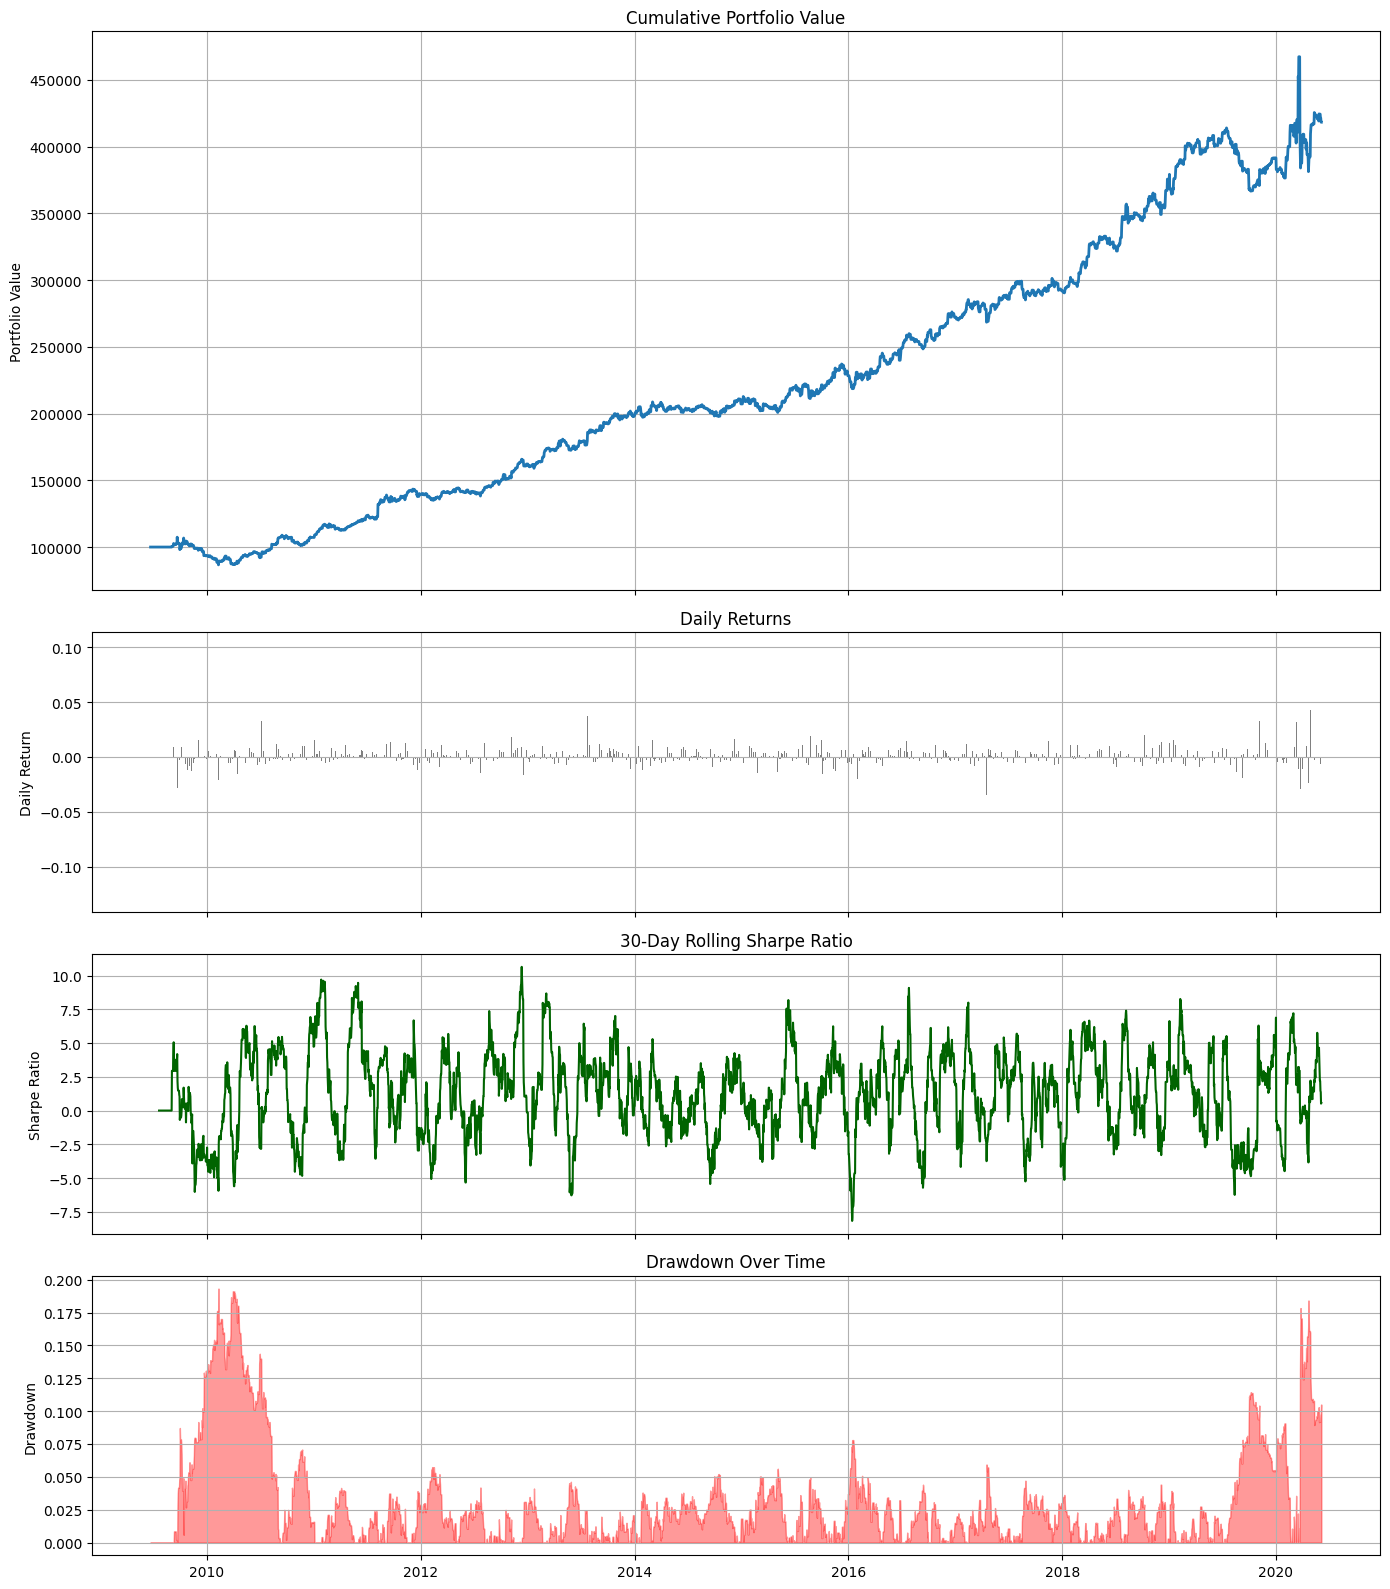

In [69]:

plot_backtest_results(returns_df, initial_capital=100_000, rolling_window=30)


In [ ]:

def generate_backtest_report(returns_df, initial_capital=100_000):
    results = {}
    
    returns_df['Cumulative Return'] = (1 + returns_df['Daily Return']).cumprod()
    final_value = initial_capital * returns_df['Cumulative Return'].iloc[-1]
    
    total_days = len(returns_df)
    total_years = total_days / 252
    total_return = returns_df['Cumulative Return'].iloc[-1] - 1
    cagr = (1 + total_return) ** (1 / total_years) - 1
    
    annualized_volatility = np.std(returns_df['Daily Return']) * np.sqrt(252)
    sharpe_ratio = (np.mean(returns_df['Daily Return']) / np.std(returns_df['Daily Return'])) * np.sqrt(252) if np.std(returns_df['Daily Return']) > 0 else 0
    
    cum_val = initial_capital * returns_df['Cumulative Return']
    rolling_max = cum_val.cummax()
    drawdown = (rolling_max - cum_val) / rolling_max
    max_drawdown = drawdown.max()
    
    positive_days = (returns_df['Daily Return'] > 0).sum()
    negative_days = (returns_df['Daily Return'] < 0).sum()
    pct_positive = positive_days / total_days
    win_loss_ratio = positive_days / max(1, negative_days)
    
    results["Final Portfolio Value"] = f"${final_value:,.2f}"
    results["Total Return (%)"] = f"{total_return * 100:.2f}%"
    results["CAGR"] = f"{cagr * 100:.2f}%"
    results["Annualized Volatility"] = f"{annualized_volatility:.4f}"
    results["Sharpe Ratio"] = f"{sharpe_ratio:.2f}"
    results["Max Drawdown"] = f"{max_drawdown * 100:.2f}%"
    results["Positive Days (%)"] = f"{pct_positive * 100:.2f}%"
    results["Win/Loss Ratio"] = f"{win_loss_ratio:.2f}"
    
    return pd.DataFrame.from_dict(results, orient='index', columns=["Value"])
generate_backtest_report(returns_df, initial_capital=100_000)

In [ ]:
generate_backtest_report(returns_df, initial_capital=100_000)

In [ ]:

strategies = [
    {
        "name": "baseline",
        "params": dict(top_n=5, max_hold_days=3, sentiment_zscore_threshold=1.5,
                       per_ticker_stop_loss=0.05, max_drawdown_pct=0.15, volatility_window=20)
    },
    {
        "name": "high_sharpe",
        "params": dict(top_n=4, max_hold_days=2, sentiment_zscore_threshold=2.0,
                       per_ticker_stop_loss=0.03, max_drawdown_pct=0.10, volatility_window=15)
    },
    {
        "name": "aggressive",
        "params": dict(top_n=8, max_hold_days=5, sentiment_zscore_threshold=1.0,
                       per_ticker_stop_loss=0.07, max_drawdown_pct=0.20, volatility_window=20)
    },
    {
        "name": "wide_coverage",
        "params": dict(top_n=10, max_hold_days=3, sentiment_zscore_threshold=None,
                       per_ticker_stop_loss=0.05, max_drawdown_pct=0.15, volatility_window=20)
    }
]


In [72]:
returns_dict = {}
report_dict = {}


Running strategy: baseline
Drawdown exceeded on 2010-01-25 — exiting all positions.
Drawdown exceeded on 2010-03-18 — exiting all positions.
Drawdown exceeded on 2010-03-19 — exiting all positions.
Drawdown exceeded on 2010-03-20 — exiting all positions.
Drawdown exceeded on 2010-03-21 — exiting all positions.
Drawdown exceeded on 2010-03-22 — exiting all positions.
Drawdown exceeded on 2010-03-23 — exiting all positions.
Drawdown exceeded on 2010-03-24 — exiting all positions.
Drawdown exceeded on 2010-03-25 — exiting all positions.
Drawdown exceeded on 2010-03-26 — exiting all positions.
Drawdown exceeded on 2010-03-27 — exiting all positions.
Drawdown exceeded on 2010-03-28 — exiting all positions.
Drawdown exceeded on 2010-03-29 — exiting all positions.
Drawdown exceeded on 2010-03-30 — exiting all positions.
Drawdown exceeded on 2010-03-31 — exiting all positions.
Drawdown exceeded on 2010-04-01 — exiting all positions.
Drawdown exceeded on 2010-04-02 — exiting all positions.
Draw

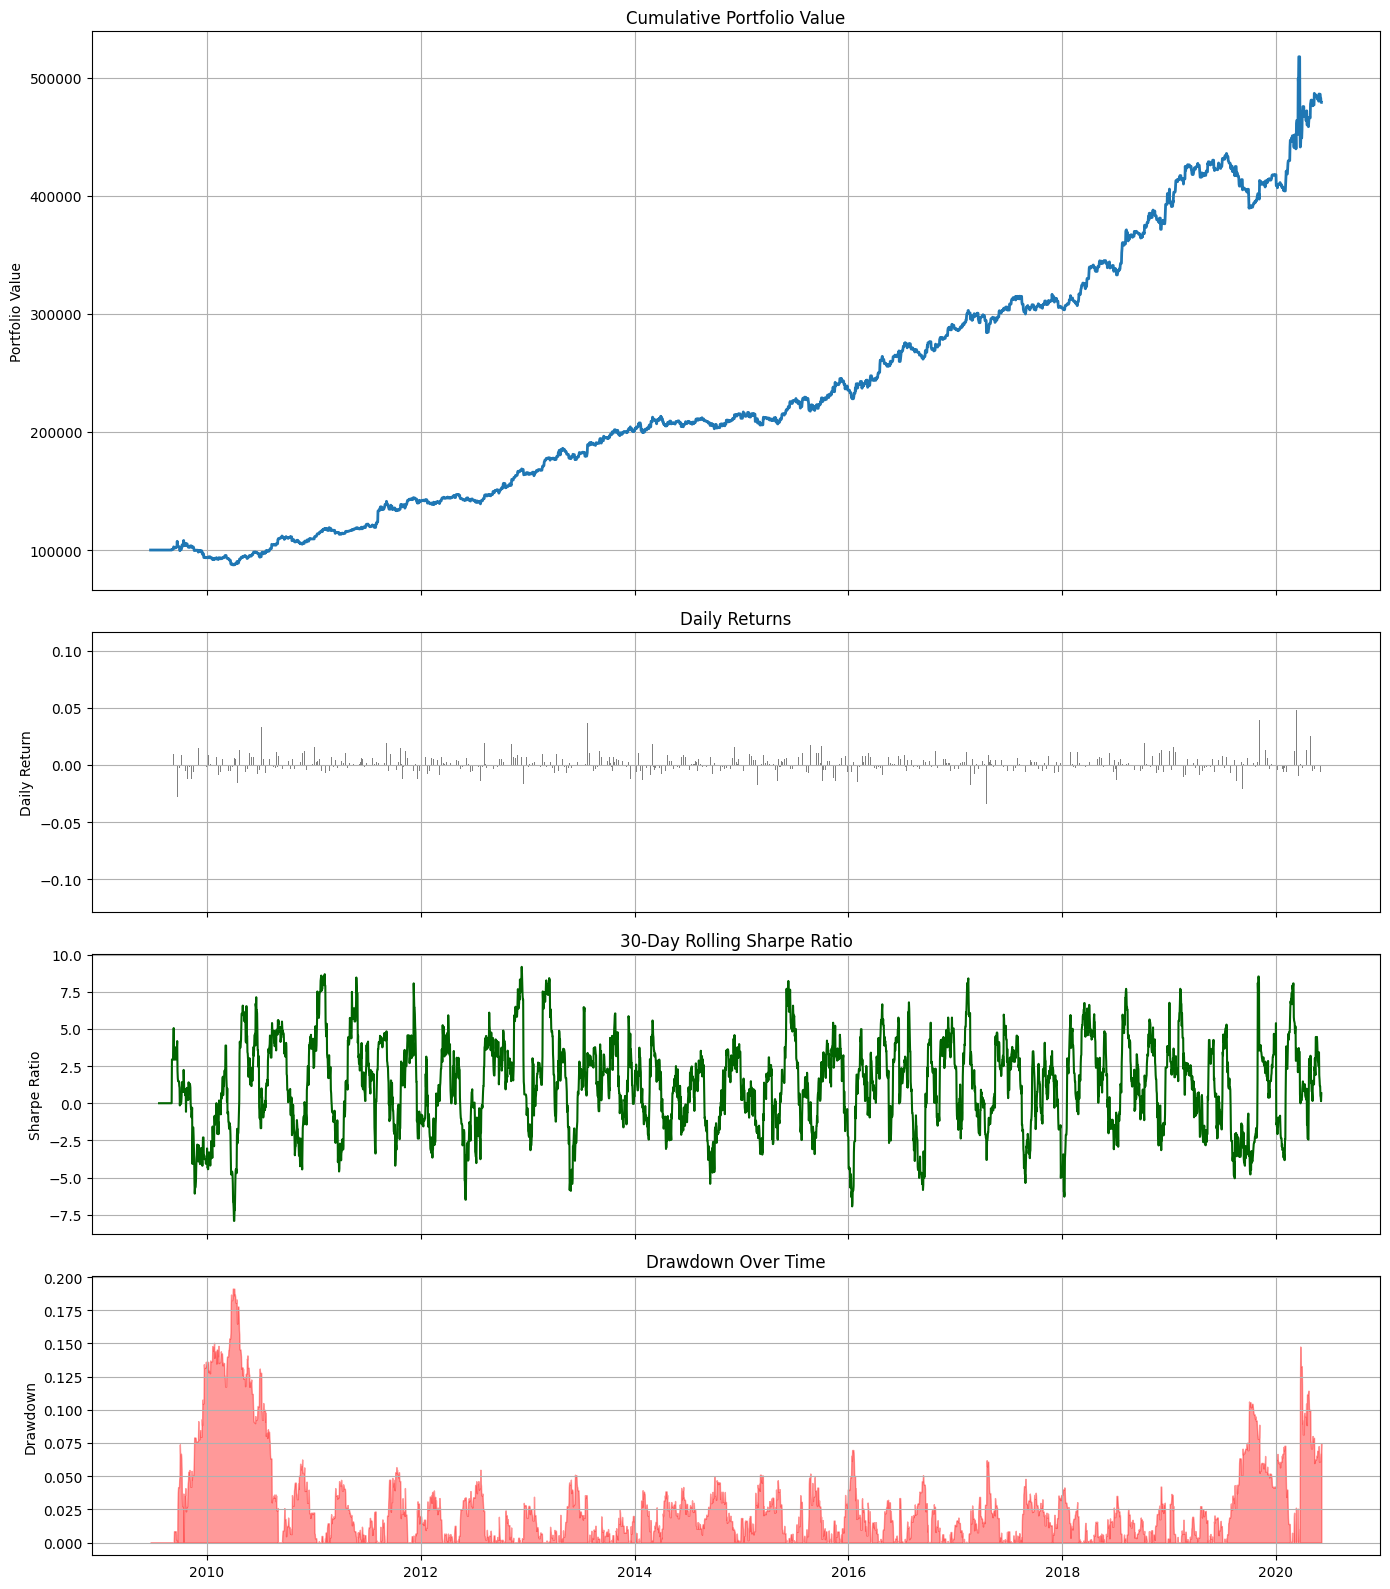

Running strategy: high_sharpe
Drawdown exceeded on 2009-12-21 — exiting all positions.
Drawdown exceeded on 2009-12-22 — exiting all positions.
Drawdown exceeded on 2009-12-23 — exiting all positions.
Drawdown exceeded on 2009-12-24 — exiting all positions.
Drawdown exceeded on 2009-12-25 — exiting all positions.
Drawdown exceeded on 2009-12-26 — exiting all positions.
Drawdown exceeded on 2009-12-27 — exiting all positions.
Drawdown exceeded on 2009-12-28 — exiting all positions.
Drawdown exceeded on 2010-01-04 — exiting all positions.
Drawdown exceeded on 2010-01-05 — exiting all positions.
Drawdown exceeded on 2010-01-06 — exiting all positions.
Drawdown exceeded on 2010-01-07 — exiting all positions.
Drawdown exceeded on 2010-01-08 — exiting all positions.
Drawdown exceeded on 2010-01-09 — exiting all positions.
Drawdown exceeded on 2010-01-10 — exiting all positions.
Drawdown exceeded on 2010-01-11 — exiting all positions.
Drawdown exceeded on 2010-01-12 — exiting all positions.
D

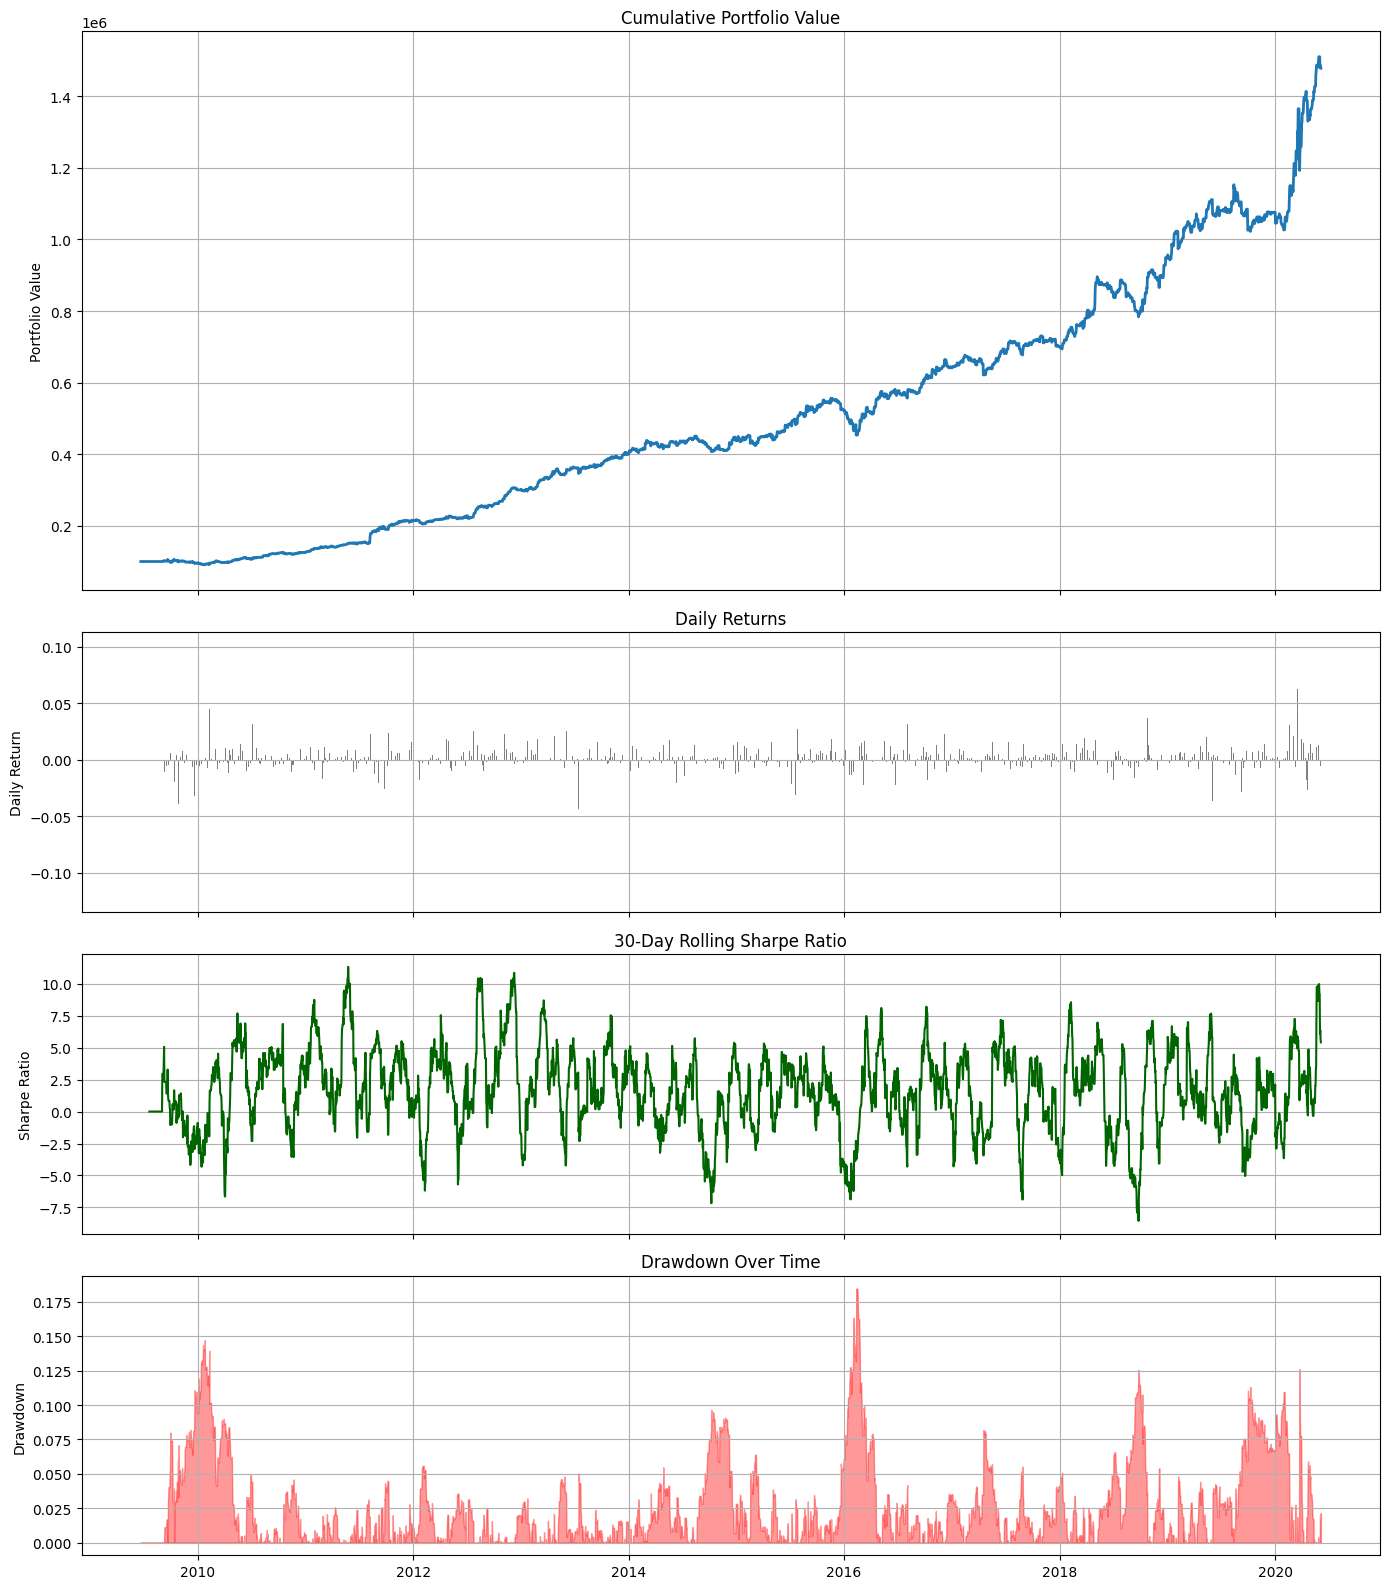

Running strategy: aggressive
Performance for: aggressive


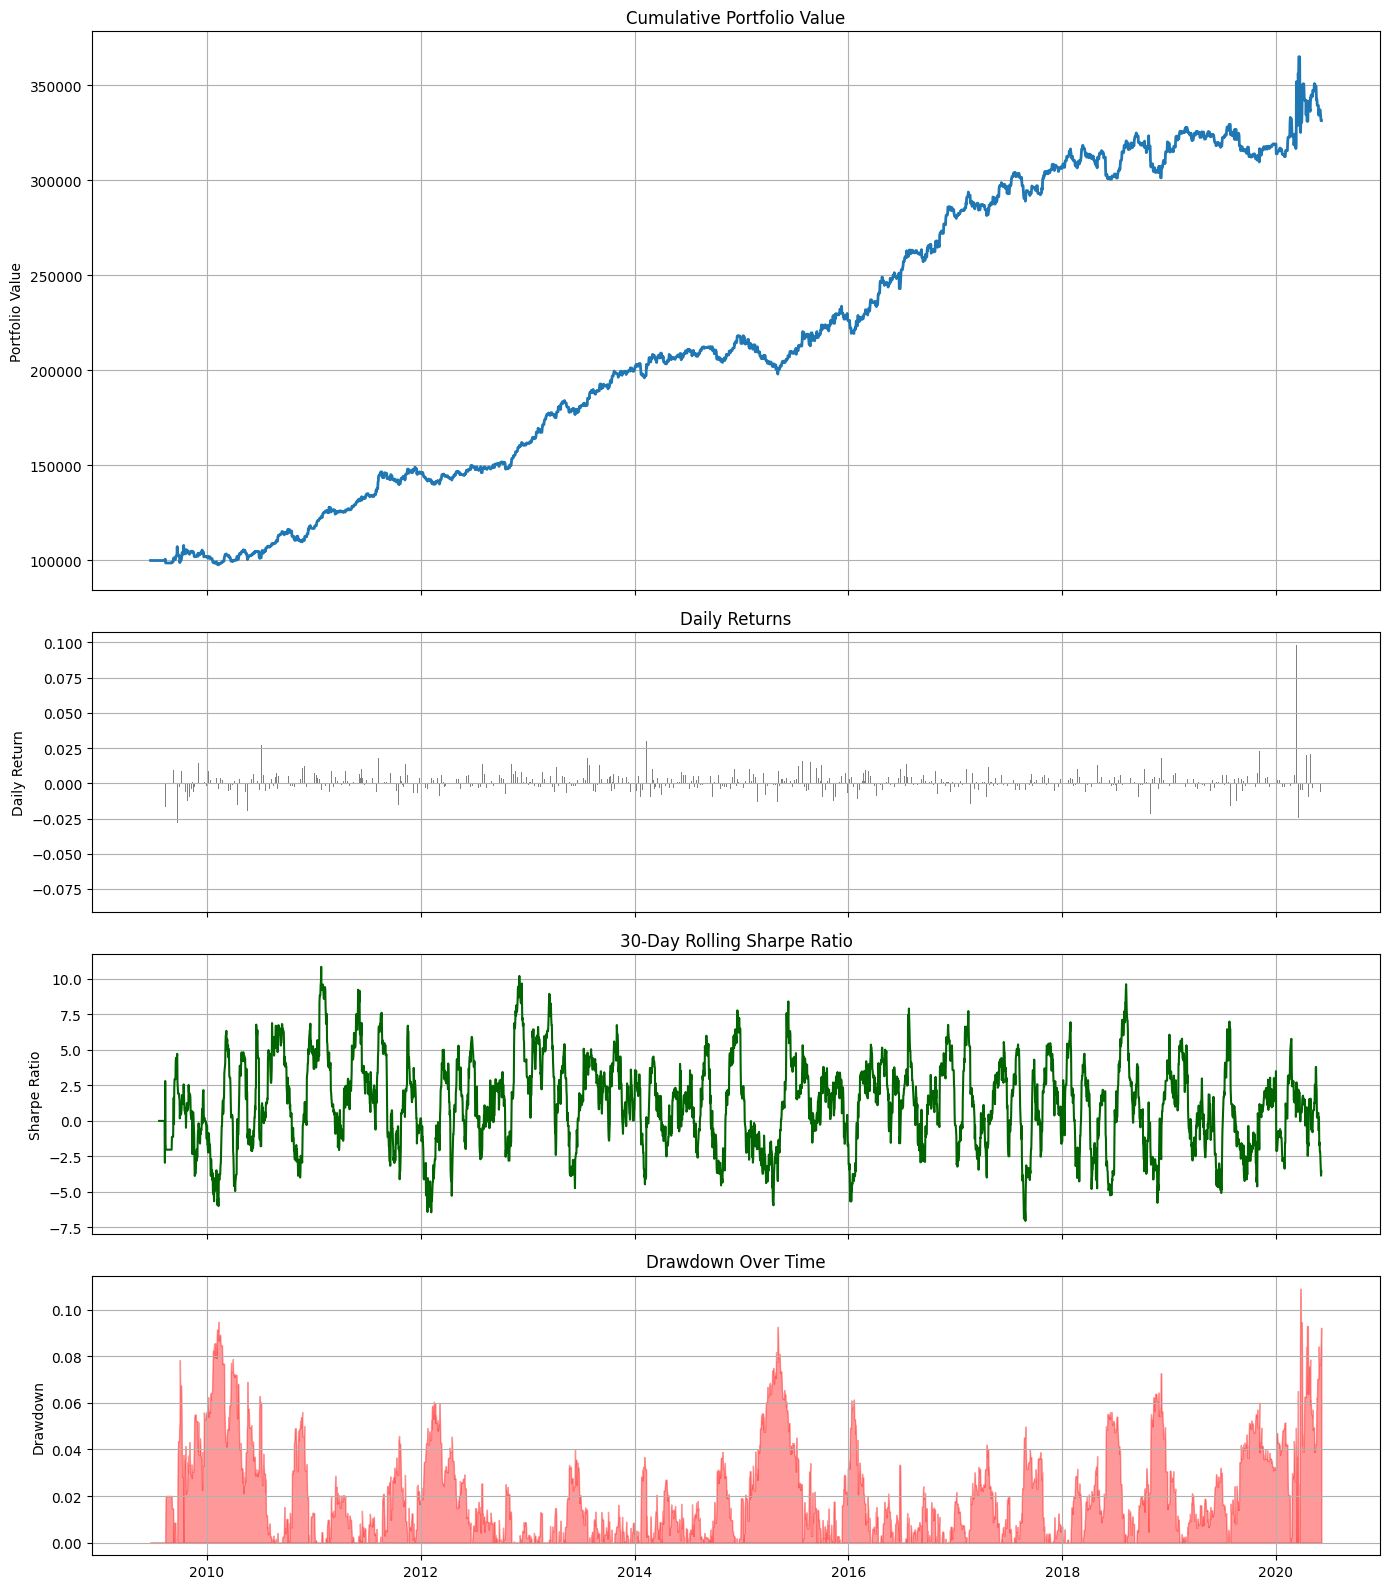

Running strategy: wide_coverage
Performance for: wide_coverage


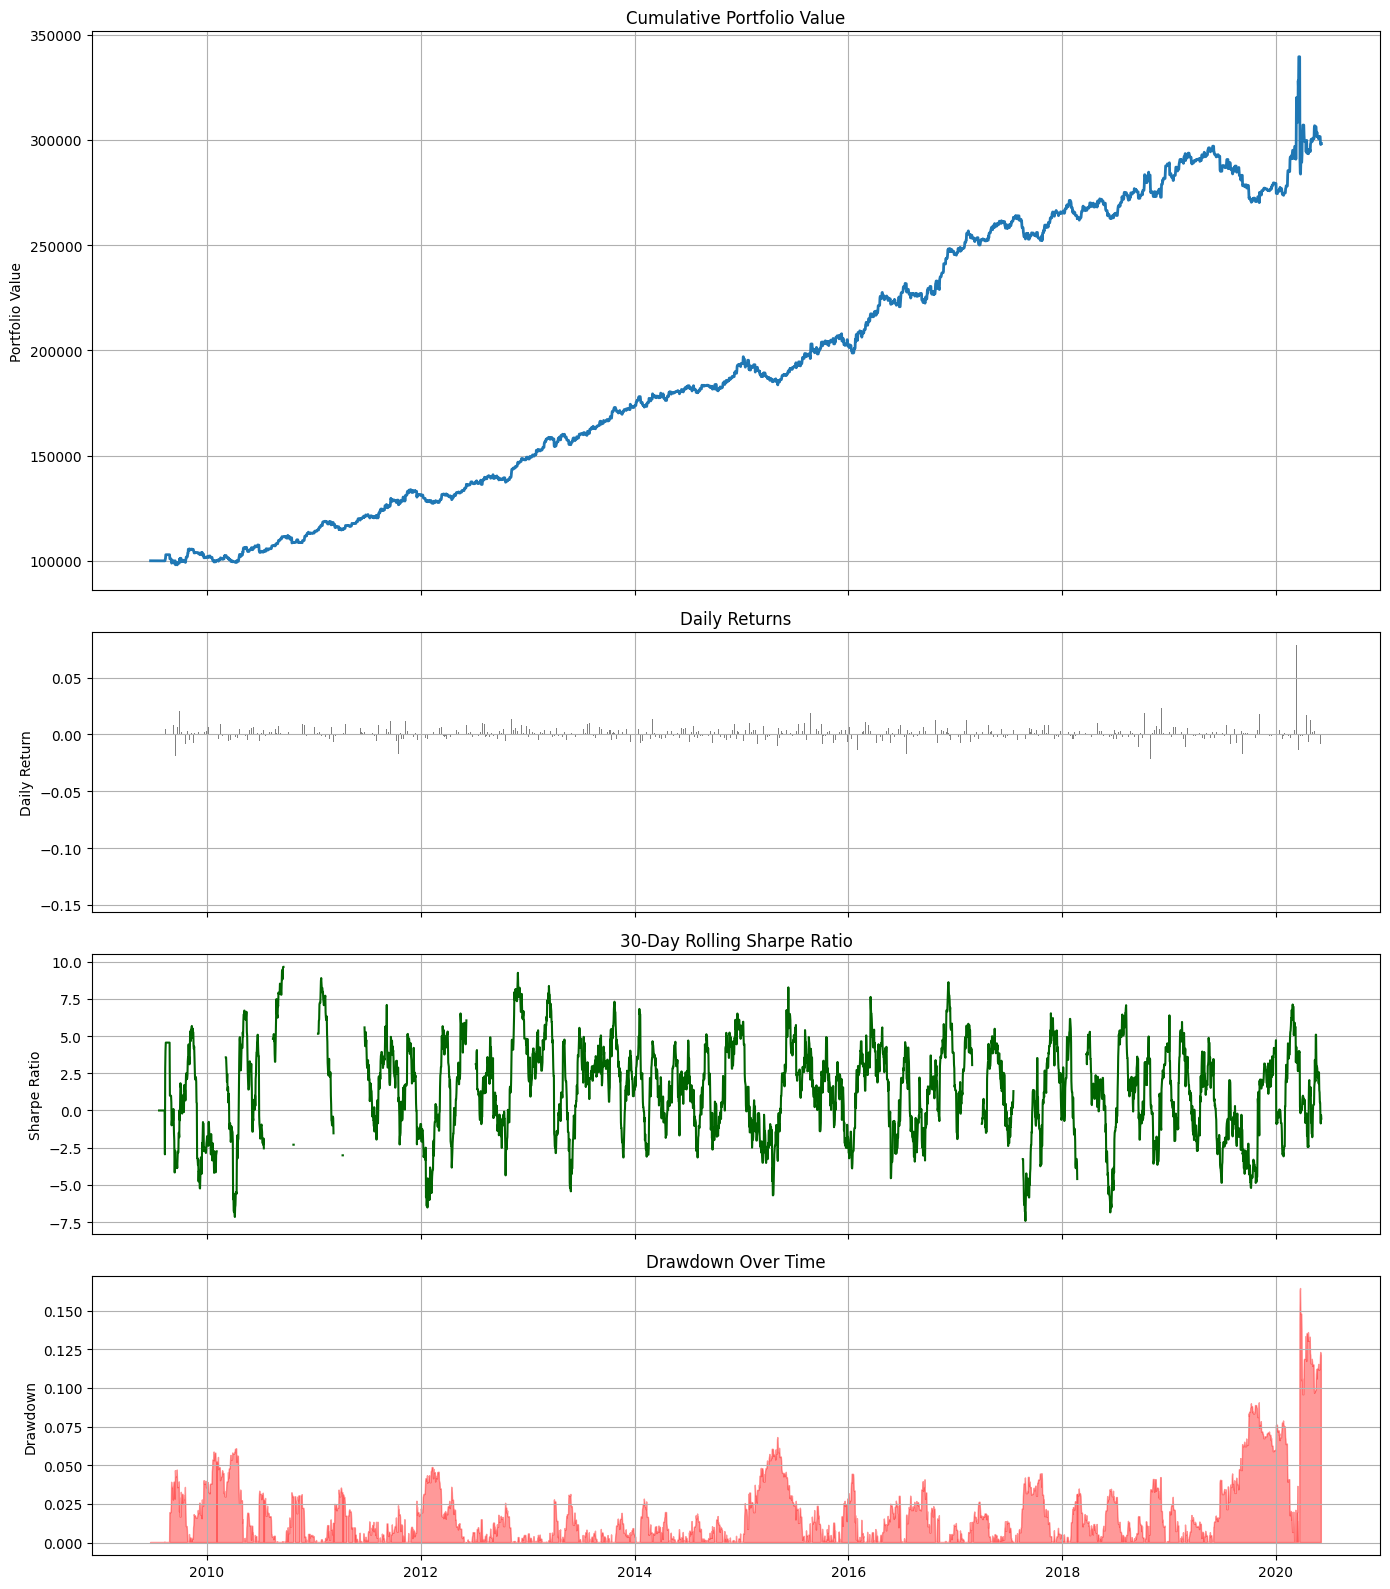

,baseline,high_sharpe,aggressive,wide_coverage
,Value,Value,Value,Value
Final Portfolio Value,"$479,113.31","$1,478,270.46","$331,349.30","$298,343.31"
Total Return (%),379.11%,1378.27%,231.35%,198.34%
CAGR,10.37%,18.49%,7.84%,7.13%
Annualized Volatility,0.0981,0.1212,0.0851,0.0759
Sharpe Ratio,1.06,1.46,0.93,0.95
Max Drawdown,19.13%,18.48%,10.91%,16.43%
Positive Days (%),29.09%,29.32%,28.97%,29.07%
Win/Loss Ratio,1.24,1.34,1.21,1.26


In [73]:
for strat in strategies:
    name = strat["name"]
    print(f"Running strategy: {name}")

    returns_df, final_val, sharpe = run_sentiment_extreme_backtest(
        sentiment_dict=sentiment_by_ticker,
        price_data=stock_price_data,
        initial_capital=100_000,
        **strat["params"]
    )

    returns_dict[name] = returns_df
    report_df = generate_backtest_report(returns_df, initial_capital=100_000)
    report_dict[name] = report_df

    print(f"Performance for: {name}")
    plot_backtest_results(returns_df, initial_capital=100_000)

# Combine all reports into one final DataFrame
combined_report = pd.concat({name: df for name, df in report_dict.items()}, axis=1)
display(combined_report)



In [74]:
def run_sentiment_extreme_backtest_with_logging(
    sentiment_dict, price_data, initial_capital=100_000, top_n=5,
    max_hold_days=3, sentiment_zscore_threshold=None,
    per_ticker_stop_loss=0.05, max_drawdown_pct=0.15,
    volatility_window=20, return_trade_log=False
):
    sentiment_z = {}
    for ticker, date_dict in sentiment_dict.items():
        all_scores = [np.mean(scores) for scores in date_dict.values()]
        all_dates = [pd.to_datetime(k) for k in date_dict.keys()]
        if len(all_scores) >= 2:
            zscores = zscore(all_scores)
            sentiment_z[ticker] = dict(zip([str(d.date()) for d in all_dates], zscores))

    tickers = list(price_data.keys())
    start_date = min(pd.to_datetime(k) for t in sentiment_dict.values() for k in t.keys())
    end_date = max(df.index.max() for df in price_data.values() if not df.empty)
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")

    portfolio_value = initial_capital
    daily_returns = []
    current_positions = {}
    peak_value = initial_capital
    trade_log = []

    for current_date in all_dates:
        date_str = str(current_date.date())

        daily_signals = []
        for ticker in tickers:
            z_val = sentiment_z.get(ticker, {}).get(date_str)
            if z_val is not None:
                daily_signals.append((ticker, z_val))

        if sentiment_zscore_threshold is not None:
            filtered_signals = [(t, z) for t, z in daily_signals if abs(z) >= sentiment_zscore_threshold]
        else:
            filtered_signals = sorted(daily_signals, key=lambda x: abs(x[1]), reverse=True)[:top_n]

        new_positions = {}
        for ticker, z_val in filtered_signals[:top_n]:
            direction = np.sign(z_val)
            try:
                entry_price = price_data[ticker].loc[current_date + timedelta(days=1), 'Close']
            except:
                continue
            new_positions[ticker] = (direction, 0, entry_price)

        updated_positions = {}
        for ticker, (direction, days_held, entry_price) in current_positions.items():
            if days_held + 1 <= max_hold_days:
                updated_positions[ticker] = (direction, days_held + 1, entry_price)

        for ticker in new_positions:
            updated_positions[ticker] = new_positions[ticker]

        inv_vols = {}
        for ticker, (direction, _, _) in updated_positions.items():
            try:
                vol = price_data[ticker].loc[current_date, 'Volatility']
                if not pd.isna(vol) and vol > 0:
                    inv_vols[ticker] = 1 / vol
            except:
                continue

        total_inv_vol = sum(inv_vols.values())
        weights = {t: inv_vols[t] / total_inv_vol for t in inv_vols}

        portfolio_return = 0
        new_positions_for_next_day = {}

        for ticker in weights.keys():
            direction, days_held, entry_price = updated_positions[ticker]
            try:
                price_now = price_data[ticker].loc[current_date + timedelta(days=1), 'Close']
                r = price_data[ticker].loc[current_date + timedelta(days=1), 'Return']
            except:
                continue

            pnl = direction * (price_now - entry_price) / entry_price

            if pnl <= -per_ticker_stop_loss:
                trade_log.append({
                    "Date": current_date + timedelta(days=1),
                    "Ticker": ticker,
                    "Direction": direction,
                    "Entry Price": entry_price,
                    "Exit Price": price_now,
                    "PnL": pnl,
                    "Holding Days": days_held + 1,
                    "Stop Loss Hit": True
                })
                continue

            portfolio_return += weights.get(ticker, 0) * direction * r
            new_positions_for_next_day[ticker] = (direction, days_held, entry_price)

            if days_held + 1 == max_hold_days:
                trade_log.append({
                    "Date": current_date + timedelta(days=1),
                    "Ticker": ticker,
                    "Direction": direction,
                    "Entry Price": entry_price,
                    "Exit Price": price_now,
                    "PnL": pnl,
                    "Holding Days": days_held + 1,
                    "Stop Loss Hit": False
                })

        current_positions = new_positions_for_next_day
        portfolio_value *= (1 + portfolio_return)
        peak_value = max(peak_value, portfolio_value)

        if (peak_value - portfolio_value) / peak_value > max_drawdown_pct:
            current_positions.clear()

        daily_returns.append(portfolio_return)

    returns_df = pd.DataFrame({'Date': all_dates, 'Daily Return': daily_returns}).set_index('Date')
    sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252) if np.std(daily_returns) > 0 else 0

    trade_log_df = pd.DataFrame(trade_log)
    return returns_df, portfolio_value, sharpe_ratio, trade_log_df


In [75]:
high_sharpe_params = dict(
    top_n=4,
    max_hold_days=2,
    sentiment_zscore_threshold=2.0,
    per_ticker_stop_loss=0.03,
    max_drawdown_pct=0.10,
    volatility_window=15
)


In [76]:

returns_df, final_val, sharpe, trade_log = run_sentiment_extreme_backtest_with_logging(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    return_trade_log=True,
    **high_sharpe_params
)


Total Trades: 3443
Win Rate: 50.51%
Avg PnL: -0.0007
Max Win: 16.57%
Max Loss: -35.80%


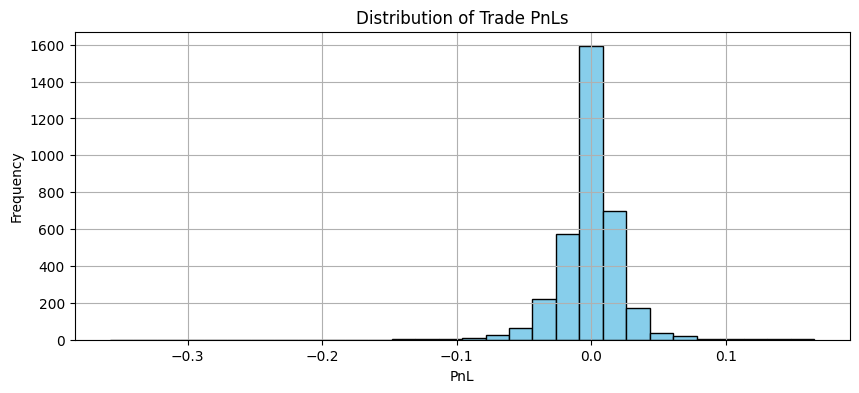

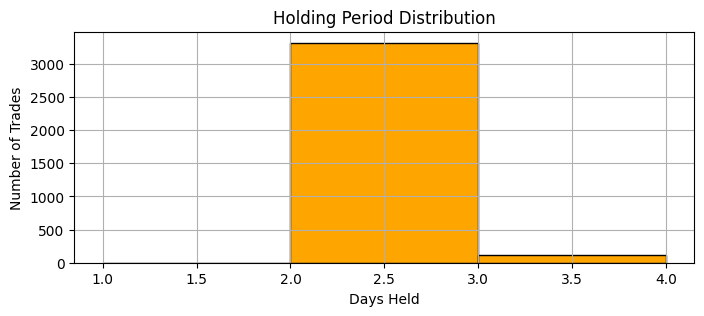


🏅 Top 10 Trades by PnL:


,Date,Ticker,Direction,Entry Price,Exit Price,PnL,Holding Days,Stop Loss Hit
3361,2020-03-12,AMP,-1.0,101.119736,84.360741,0.165734,2,False
1580,2014-02-27,WDAY,1.0,100.279999,115.470001,0.151476,2,False
2952,2018-07-26,AMD,1.0,16.049999,18.350000,0.143302,2,False
3379,2020-03-20,POOL,-1.0,183.315979,158.646286,0.134575,2,False
450,2010-12-09,AIG,1.0,26.832960,30.366610,0.131691,2,False
1264,2013-01-24,AAPL,-1.0,15.585341,13.659650,0.123558,2,False
1323,2013-04-19,CMG,1.0,6.567200,7.325000,0.115392,2,False
3370,2020-03-18,BWA,-1.0,18.139151,16.055878,0.114850,2,False
3376,2020-03-20,BX,-1.0,35.021259,31.418207,0.102882,2,False
1404,2013-07-17,TSLA,1.0,7.270000,8.016667,0.102705,2,False



❌ Worst 10 Trades by PnL:


,Date,Ticker,Direction,Entry Price,Exit Price,PnL,Holding Days,Stop Loss Hit
3363,2020-03-12,NCLH,1.0,15.030000,9.650000,-0.357951,2,True
3364,2020-03-13,BX,-1.0,33.411556,38.966251,-0.166251,2,True
3277,2019-11-20,TGT,-1.0,96.800262,110.405571,-0.140550,2,True
3374,2020-03-19,CFG,-1.0,12.023963,13.632916,-0.133812,2,True
24,2009-10-29,LVS,-1.0,8.461028,9.482519,-0.120729,2,True
1755,2014-10-10,AVGO,1.0,6.088283,5.390320,-0.114640,2,True
1204,2012-11-15,NTAP,-1.0,20.293865,22.598625,-0.113569,2,True
2242,2016-04-29,WDC,1.0,32.553097,28.885038,-0.112679,2,True
3362,2020-03-12,BLK,1.0,379.166748,339.795776,-0.103836,2,True
3408,2020-04-17,BLDR,-1.0,13.250000,14.620000,-0.103396,3,True


In [77]:
returns_df.to_csv("high_sharpe_daily_returns.csv")
trade_log.to_csv("high_sharpe_trade_log.csv", index=False)

total_trades = len(trade_log)
wins = trade_log[trade_log["PnL"] > 0]
losses = trade_log[trade_log["PnL"] <= 0]
win_rate = len(wins) / total_trades if total_trades > 0 else 0
avg_pnl = trade_log["PnL"].mean()
max_win = trade_log["PnL"].max()
max_loss = trade_log["PnL"].min()

print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Avg PnL: {avg_pnl:.4f}")
print(f"Max Win: {max_win:.2%}")
print(f"Max Loss: {max_loss:.2%}")

plt.figure(figsize=(10, 4))
plt.hist(trade_log["PnL"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Trade PnLs")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(trade_log["Holding Days"], bins=range(1, max(trade_log["Holding Days"]) + 2), color="orange", edgecolor="black")
plt.title("Holding Period Distribution")
plt.xlabel("Days Held")
plt.ylabel("Number of Trades")
plt.grid(True)
plt.show()

print("\n🏅 Top 10 Trades by PnL:")
display(trade_log.sort_values("PnL", ascending=False).head(10))

print("\n❌ Worst 10 Trades by PnL:")
display(trade_log.sort_values("PnL").head(10))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import os

# Create output folder
os.makedirs("figures_for_overleaf", exist_ok=True)

# === Baseline Strategy Plot ===
baseline_returns_df = returns_dict.get("baseline").copy()
baseline_returns_df["Portfolio Value"] = 100_000 * (1 + baseline_returns_df["Daily Return"]).cumprod()

fig1 = plt.figure(figsize=(12, 5))
sns.lineplot(data=baseline_returns_df, x=baseline_returns_df.index, y="Portfolio Value")
plt.title("Baseline Strategy – Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${int(x):,}"))
plt.tight_layout()
fig1.savefig("figures_for_overleaf/baseline_equity.png", dpi=300)
plt.close(fig1)


# === All Strategy Curves Plot ===
fig2 = plt.figure(figsize=(12, 5))
for name, df in returns_dict.items():
    df = df.copy()
    df["Portfolio Value"] = 100_000 * (1 + df["Daily Return"]).cumprod()
    plt.plot(df.index, df["Portfolio Value"], label=name.replace("_", " ").title())

plt.title("Equity Curves for All Strategies (2009–2020)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${int(x):,}"))
plt.legend()
plt.tight_layout()
fig2.savefig("figures_for_overleaf/strategy_equity_curves.png", dpi=300)
plt.close(fig2)

print("Saved with dollar-formatted y-axis to 'figures_for_overleaf/'")


✅ Saved with dollar-formatted y-axis to 'figures_for_overleaf/'


In [79]:
returns_df, final_val, sharpe = run_sentiment_extreme_backtest(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    initial_capital=100_000,
    top_n=4,
    max_hold_days=2,
    sentiment_zscore_threshold=2.0,
    per_ticker_stop_loss=0.03,
    max_drawdown_pct=0.10,
    volatility_window=15
)

report = generate_backtest_report(returns_df, initial_capital=100_000)
print(report)


Drawdown exceeded on 2009-12-21 — exiting all positions.
Drawdown exceeded on 2009-12-22 — exiting all positions.
Drawdown exceeded on 2009-12-23 — exiting all positions.
Drawdown exceeded on 2009-12-24 — exiting all positions.
Drawdown exceeded on 2009-12-25 — exiting all positions.
Drawdown exceeded on 2009-12-26 — exiting all positions.
Drawdown exceeded on 2009-12-27 — exiting all positions.
Drawdown exceeded on 2009-12-28 — exiting all positions.
Drawdown exceeded on 2010-01-04 — exiting all positions.
Drawdown exceeded on 2010-01-05 — exiting all positions.
Drawdown exceeded on 2010-01-06 — exiting all positions.
Drawdown exceeded on 2010-01-07 — exiting all positions.
Drawdown exceeded on 2010-01-08 — exiting all positions.
Drawdown exceeded on 2010-01-09 — exiting all positions.
Drawdown exceeded on 2010-01-10 — exiting all positions.
Drawdown exceeded on 2010-01-11 — exiting all positions.
Drawdown exceeded on 2010-01-12 — exiting all positions.
Drawdown exceeded on 2010-01-13

In [102]:
'''
sp500 = yf.download(
    '^GSPC',
    start=min(df.index.min() for df in returns_dict.values() if not df.empty),
    end=max(df.index.max() for df in returns_dict.values() if not df.empty),
    interval='1d',
    group_by='ticker',
    auto_adjust=True,
    multi_level_index=False
)
sp500 = sp500.sort_index()
sp500['Market Return'] = np.log(sp500['Close']) - np.log(sp500['Close'].shift(1))
sp500['Market Return'] = sp500['Market Return'].shift(-1)
sp500 = sp500[['Market Return']].dropna()
'''



sp500 = joblib.load("sp500.pkl")
#Regression and Summary Table
summary_rows = []

for strategy_name, strat_df in returns_dict.items():
    if strat_df.empty or 'Daily Return' not in strat_df.columns:
        continue

    combined = strat_df.copy().merge(sp500, left_index=True, right_index=True, how='inner')
    combined.dropna(inplace=True)

    # Regression: Strategy ~ Market
    X = sm.add_constant(combined['Market Return'])
    y = combined['Daily Return']
    model = sm.OLS(y, X).fit()

    summary_rows.append({
        'Strategy': strategy_name,
        'Alpha (Intercept)': model.params['const'],
        'Beta (Market)': model.params['Market Return'],
        'R-squared': model.rsquared,
        't-stat (Beta)': model.tvalues['Market Return'],
        'p-value (Beta)': model.pvalues['Market Return'],
        'Obs': int(model.nobs)
    })

# === Step 3: Format Summary Table ===
beta_summary = pd.DataFrame(summary_rows)
beta_summary = beta_summary.sort_values(by='R-squared', ascending=False).reset_index(drop=True)


In [103]:
print(beta_summary)

        Strategy  Alpha (Intercept)  Beta (Market)  R-squared  t-stat (Beta)  \
0  wide_coverage           0.000447      -0.064056   0.014968      -6.427739   
1       baseline           0.000587       0.025409   0.001411       1.972664   
2    high_sharpe           0.001009       0.028283   0.001147       1.778246   
3     aggressive           0.000458      -0.000761   0.000002      -0.067984   

   p-value (Beta)   Obs  
0    1.524204e-10  2721  
1    4.863377e-02  2756  
2    7.547380e-02  2756  
3    9.458032e-01  2756  


In [ ]:
#Placebo tests below

def create_placebo_sentiment(sentiment_dict, method="shuffle", shift_days=30):

    if method == "shuffle":
        all_dates = list({date for ticker_data in sentiment_dict.values() for date in ticker_data})
        placebo = {}
        for ticker, date_dict in sentiment_dict.items():
            placebo[ticker] = {}
            for _ in date_dict:
                rand_date = random.choice(all_dates)
                scores = random.choice(list(date_dict.values()))
                if rand_date not in placebo[ticker]:
                    placebo[ticker][rand_date] = []
                placebo[ticker][rand_date].extend(scores)
        return placebo

    elif method == "shift":
        placebo = {}
        for ticker, date_dict in sentiment_dict.items():
            placebo[ticker] = {}
            for date_str, scores in date_dict.items():
                try:
                    old_date = pd.to_datetime(date_str)
                    new_date = (old_date + pd.Timedelta(days=shift_days)).strftime('%Y-%m-%d')
                    if new_date not in placebo[ticker]:
                        placebo[ticker][new_date] = []
                    placebo[ticker][new_date].extend(scores)
                except:
                    continue
        return placebo

    else:
        raise ValueError("Invalid method. Use 'shuffle' or 'shift'.")


def run_placebo_experiment(sentiment_dict, price_data, method="shuffle", shift_days=30, 
                           **kwargs):
    """
    Runs placebo regression and compares with real results.

    kwargs passed to run_regression_on_sentiments
    Returns:
        real_r2, placebo_r2_dict, full results
    """
    print(f"Running actual model...")
    real_models = run_regression_on_sentiments(
        sentiment_dict=sentiment_dict,
        returns_dict=price_data,
        **kwargs
    )
    real_r2 = {ticker: model.rsquared for ticker, model in real_models.items()}

    print(f"Running placebo model with method='{method}'...")
    placebo_sentiment = create_placebo_sentiment(sentiment_dict, method=method, shift_days=shift_days)
    placebo_models = run_regression_on_sentiments(
        sentiment_dict=placebo_sentiment,
        returns_dict=price_data,
        **kwargs
    )
    placebo_r2 = {ticker: model.rsquared for ticker, model in placebo_models.items()}

    
    df = pd.DataFrame({
        "Real R²": pd.Series(real_r2),
        "Placebo R²": pd.Series(placebo_r2)
    }).dropna()

    df["R² Gap"] = df["Real R²"] - df["Placebo R²"]
    df = df.sort_values("R² Gap", ascending=False)

    return df, real_models, placebo_models


In [ ]:
placebo_df, real_models, placebo_models = run_placebo_experiment(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    method="shift",  
    shift_days=30,
    lag_days=1,
    extreme_percentile=0.1,
    min_obs=30,
    compounding_days=3,
    abs_sentiment_threshold=0.15,
    use_log_returns=True,
    compounding_returns_days=5
)

print(placebo_df.head(10))  


Running actual model...
Not enough extreme obs for ADP, skipping...
Not enough extreme obs for DLTR, skipping...
Not enough data for PSX, skipping...
Not enough extreme obs for DXCM, skipping...
Not enough extreme obs for GEN, skipping...
Not enough extreme obs for NTAP, skipping...
Not enough extreme obs for AMP, skipping...
Not enough extreme obs for TMO, skipping...
Not enough extreme obs for AMGN, skipping...
Not enough data for BXP, skipping...
Not enough extreme obs for PSA, skipping...
Not enough extreme obs for TJX, skipping...
Not enough data for KEYS, skipping...
Not enough data for PH, skipping...
Not enough extreme obs for ED, skipping...
Not enough extreme obs for DFS, skipping...
Not enough data for SBUX, skipping...
Not enough data for AON, skipping...
Not enough extreme obs for NVDA, skipping...
Not enough data for SLB, skipping...
Not enough data for WAT, skipping...
Not enough extreme obs for DVA, skipping...
Not enough extreme obs for ADI, skipping...
Not enough data

In [ ]:
def run_placebo_backtest_experiment(
    sentiment_dict,
    price_data,
    method="shuffle",
    shift_days=30,
    backtest_fn=run_sentiment_extreme_backtest,
    backtest_params=None,
    initial_capital=100_000,
    verbose=True
):
    
    if backtest_params is None:
        backtest_params = {
            "top_n": 5,
            "max_hold_days": 3,
            "sentiment_zscore_threshold": 1.5,
            "per_ticker_stop_loss": 0.05,
            "max_drawdown_pct": 0.15,
            "volatility_window": 20
        }

    
    actual_returns, actual_val, actual_sharpe = backtest_fn(
        sentiment_dict=sentiment_dict,
        price_data=price_data,
        initial_capital=initial_capital,
        **backtest_params
    )

    
    placebo_sentiment = create_placebo_sentiment(sentiment_dict, method=method, shift_days=shift_days)

    
    placebo_returns, placebo_val, placebo_sharpe = backtest_fn(
        sentiment_dict=placebo_sentiment,
        price_data=price_data,
        initial_capital=initial_capital,
        **backtest_params
    )

    
    def summarize(returns_df, final_val, sharpe):
        cum_val = final_val
        total_return = cum_val / initial_capital - 1
        daily = returns_df["Daily Return"]
        max_dd = ((1 + daily).cumprod().cummax() - (1 + daily).cumprod()) / (1 + daily).cumprod().cummax()
        return {
            "Final Value": cum_val,
            "Total Return (%)": total_return * 100,
            "Sharpe": sharpe,
            "Max Drawdown (%)": max_dd.max() * 100
        }

    actual_summary = summarize(actual_returns, actual_val, actual_sharpe)
    placebo_summary = summarize(placebo_returns, placebo_val, placebo_sharpe)

    df = pd.DataFrame([actual_summary, placebo_summary], index=["Actual", f"Placebo ({method})"])
    if verbose:
        print(df)

    return df, {"actual": actual_returns, "placebo": placebo_returns}


In [ ]:
placebo_bt_summary, placebo_bt_returns = run_placebo_backtest_experiment(
    sentiment_dict=sentiment_by_ticker,
    price_data=stock_price_data,
    method="shuffle",  
    shift_days=45,     
    backtest_fn=run_sentiment_extreme_backtest,
    backtest_params=high_sharpe_params  
)


Drawdown exceeded on 2009-12-21 — exiting all positions.
Drawdown exceeded on 2009-12-22 — exiting all positions.
Drawdown exceeded on 2009-12-23 — exiting all positions.
Drawdown exceeded on 2009-12-24 — exiting all positions.
Drawdown exceeded on 2009-12-25 — exiting all positions.
Drawdown exceeded on 2009-12-26 — exiting all positions.
Drawdown exceeded on 2009-12-27 — exiting all positions.
Drawdown exceeded on 2009-12-28 — exiting all positions.
Drawdown exceeded on 2010-01-04 — exiting all positions.
Drawdown exceeded on 2010-01-05 — exiting all positions.
Drawdown exceeded on 2010-01-06 — exiting all positions.
Drawdown exceeded on 2010-01-07 — exiting all positions.
Drawdown exceeded on 2010-01-08 — exiting all positions.
Drawdown exceeded on 2010-01-09 — exiting all positions.
Drawdown exceeded on 2010-01-10 — exiting all positions.
Drawdown exceeded on 2010-01-11 — exiting all positions.
Drawdown exceeded on 2010-01-12 — exiting all positions.
Drawdown exceeded on 2010-01-13

/var/folders/gm/kf61wf7d0rngwszt66rdf98r0000gn/T/ipykernel_58583/215866709.py:21: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zscores = zscore(all_scores)


Drawdown exceeded on 2009-10-26 — exiting all positions.
Drawdown exceeded on 2009-10-27 — exiting all positions.
Drawdown exceeded on 2009-10-28 — exiting all positions.
Drawdown exceeded on 2009-10-29 — exiting all positions.
Drawdown exceeded on 2009-10-30 — exiting all positions.
Drawdown exceeded on 2009-10-31 — exiting all positions.
Drawdown exceeded on 2009-11-01 — exiting all positions.
Drawdown exceeded on 2009-11-02 — exiting all positions.
Drawdown exceeded on 2009-11-03 — exiting all positions.
Drawdown exceeded on 2009-11-04 — exiting all positions.
Drawdown exceeded on 2009-11-05 — exiting all positions.
Drawdown exceeded on 2009-11-06 — exiting all positions.
Drawdown exceeded on 2009-11-07 — exiting all positions.
Drawdown exceeded on 2009-11-08 — exiting all positions.
Drawdown exceeded on 2009-11-09 — exiting all positions.
Drawdown exceeded on 2009-11-10 — exiting all positions.
Drawdown exceeded on 2009-11-11 — exiting all positions.
Drawdown exceeded on 2009-11-12

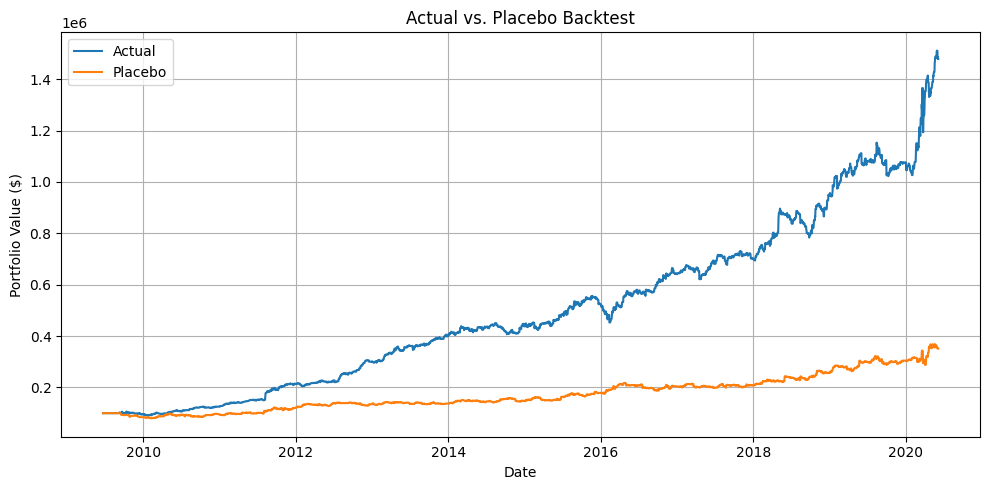

In [95]:
def plot_placebo_vs_actual(daily_returns_dict, initial_capital=100_000):
    plt.figure(figsize=(10, 5))
    for label, df in daily_returns_dict.items():
        df["Cumulative"] = (1 + df["Daily Return"]).cumprod()
        plt.plot(df.index, initial_capital * df["Cumulative"], label=label.title())

    plt.title("Actual vs. Placebo Backtest")
    plt.ylabel("Portfolio Value ($)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_placebo_vs_actual(placebo_bt_returns)
